In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/sample_submission.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train.zip
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv


In [2]:
!pip install seaborn=="v0.13.2" # supress "Futurewarning for deprecated pandas is_categorical_dtype and use_inf_as_na usage"
!pip install tldextract # it is used for extracting domain
!pip install umap-learn # use UMAP for visualizing data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import pandas as pd
import pickle

# use for sequential pattern mining
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import SparkSession

# preprocessing data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import tldextract # extract data from FQDN

# create model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Embedding, Concatenate, Flatten, Reshape, BatchNormalization, Conv1D
from tensorflow.keras.metrics import AUC
import keras
from keras.optimizers import Adamax

# metrics
from sklearn.metrics import roc_curve, auc

# plot clustering data
import umap
np.random.seed(42)
tf.random.set_seed(42) 

# 1. Project Overview
In this study, the objective is to perform Web-user identification for a specific user—referred to as Alice—by leveraging session identifiers, the sequence of visited websites, and their corresponding timestamps. The primary evaluation metric employed is the Area Under the Receiver Operating Characteristic Curve (ROC AUC). The task of Web-user identification is situated at the intersection of sequential pattern mining and behavioral psychology.

Each session ID is associated with a sequence of up to ten consecutively accessed websites. The dataset originates from proxy server logs of Blaise Pascal University, as introduced in the paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau, and Olivier Raynaud.

In [4]:
BASE_DIR = '/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2'

In [5]:
# load data
df_train = pd.read_csv(f"{BASE_DIR}/train_sessions.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test_sessions.csv")
with open(f'{BASE_DIR}/site_dic.pkl', mode="rb") as f:
    site_dic = pickle.load(f)

# 2. Exploratory Data Analysis
As part of the exploratory data analysis (EDA), we initially computed descriptive statistics to gain a comprehensive understanding of the dataset. This preliminary examination revealed a pronounced class imbalance, with a disproportionately large number of sessions associated with users other than Alice. Given that the raw input features were not inherently compatible with deep learning methodologies, we engineered a set of features capturing temporal patterns, site visitation sequences, and user activity metrics.

Following feature construction, data points deemed unsuitable for downstream analysis were excluded. To further investigate the structural characteristics of the dataset, we computed the correlation matrix and employed Uniform Manifold Approximation and Projection (UMAP) for dimensionality reduction and visualization. These steps facilitated a more nuanced understanding of the data distribution and potential class separability.

## 2.1 Descriptive Statistics
Upon examining the dataset, it is observed that each session ID is associated with up to ten records of visited websites and their corresponding timestamps. Notably, every session contains at least one recorded website visit.

The target column is binary, indicating whether the session corresponds to the target user—referred to as Alice—with a value of 1 for her sessions and 0 for all others.

Given the raw nature of the access logs, the dataset is not immediately suitable for direct analysis. It is therefore necessary to engineer meaningful features from the session-level logs in order to facilitate downstream modeling and interpretation.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19  si

In [7]:
df_train.describe()

,session_id,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
count,253561.00000,253561.000000,250098.000000,246919.000000,244321.000000,241829.000000,239495.000000,237297.000000,235224.000000,233084.000000,231052.000000,253561.000000
mean,126781.00000,3243.550144,3272.400883,3303.987757,3325.109422,3343.406035,3352.312637,3395.546771,3430.157765,3438.400088,3460.388861,0.009059
std,73196.90014,7247.006212,7307.480404,7347.809918,7371.245606,7379.758550,7380.413775,7435.727671,7473.417900,7471.062652,7492.447548,0.094747
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,63391.00000,53.000000,53.000000,53.000000,52.000000,52.000000,52.000000,55.000000,55.000000,55.000000,55.000000,0.000000
50%,126781.00000,677.000000,677.000000,677.000000,677.000000,678.000000,679.000000,679.000000,704.000000,733.000000,733.000000,0.000000
75%,190171.00000,1980.000000,1980.000000,1986.500000,1995.000000,2054.000000,2077.000000,2197.000000,2287.000000,2366.000000,2403.000000,0.000000
max,253561.00000,41601.000000,41600.000000,41599.000000,41599.000000,41599.000000,41600.000000,41600.000000,41601.000000,41601.000000,41601.000000,1.000000


## 2.2 Class Balance
Upon examining the class distribution, it is evident that the dataset is highly imbalanced: the number of sessions associated with regular users is 251,264, whereas only 2,297 sessions correspond to the target user, Alice. This severe imbalance poses challenges for both visualization—such as when generating histograms—and model training. To address this issue, downsampling of the majority class is applied to create a balanced dataset for further analysis.

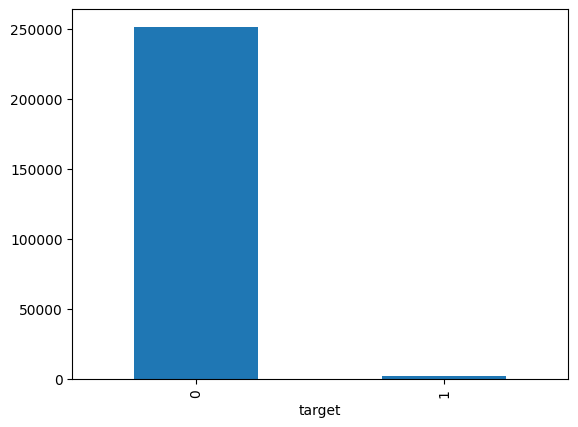

target
0    251264
1      2297
Name: count, dtype: int64


In [8]:
# plot alice or not
plot_df = df_train.target.value_counts()
plot_df.plot(kind="bar")
plt.show()

print(plot_df)

In [9]:
# definition of class to analyze the data
class UserActivityRecord:
    def __init__(self, dataset):
        # down sampling for comparing the imbalanced classes
        ros = RandomUnderSampler(sampling_strategy='auto')
        X_resampled, y_resampled = ros.fit_resample(dataset, dataset.target)
        self.df = X_resampled
        self.df_users = X_resampled[X_resampled.target == 0]
        self.df_target = X_resampled[X_resampled.target == 1]
        self.column_names = [column for column in dataset.columns]

    def plot_hist(self, record_name, ax):
        # plot histgrams between user and Alice
        sns.histplot(self.df_users[record_name], 
                     label='Users',
                     color='green',
                     element='step',
                     ax=ax,
                     kde=True)
        sns.histplot(self.df_target[record_name],
                     label='Alice', 
                     color='red',
                     element='step',
                     ax=ax,
                     kde=True)

    def plot_boxplot(self, record_name, ax):
        # plot boxplot
        sns.boxplot(data=self.df, x="target", y=record_name, ax=ax)


## 2.2 Time Operation
Given that each session includes at least one visited site and up to a maximum of ten, we initially focus on extracting meaningful features from the available timestamp information. The following features are engineered to capture session-level temporal characteristics.


### Session-Related Features

| Feature                   | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| **Session Start Time**    | Timestamp corresponding to the beginning of the session                     |
| **Session End Time**      | Timestamp marking the end of the session (i.e., the last recorded activity) |
| **Session Length**        | Duration of the session                                                     |
| **Session Start Year**    | Calendar year when the session started                                      |
| **Session Start Month**   | Calendar month of the session start                                         |
| **Session Start Day**     | Day of the month on which the session began                                 |
| **Session Start Hour**    | Hour of day when the session commenced                                      |
| **Session Start Minute**  | Minute of the hour corresponding to the session start                       |
| **Session Start Second**  | Second of the minute at which the session began                             |
| **Session Start Weekday** | Day of the week the session was initiated (e.g., Monday, Tuesday)           |

### Time-of-Day Features

| Feature                   | Description                                                              |
|---------------------------|--------------------------------------------------------------------------|
| **Is Weekend**            | Indicator variable: 1 if the session took place on a weekend, else 0     |
| **Is Midnight Activity**  | 1 if the session occurred between 00:00 and 06:00, else 0                |
| **Is Morning Activity**   | 1 if the session occurred between 06:00 and 12:00, else 0                |
| **Is Midday Activity**    | 1 if the session occurred between 12:00 and 18:00, else 0                |
| **Is Night Activity**     | 1 if the session occurred between 18:00 and 00:00, else 0                |

### Date-Related Features

| Feature                 | Description                                                              |
|-------------------------|--------------------------------------------------------------------------|
| **Is Month Start**       | 1 if the session started on the first day of the month, else 0          |
| **Is Month End**         | 1 if the session occurred on the last day of the month, else 0          |
| **Is Quarter Start**     | 1 if the session began at the start of a calendar quarter, else 0       |
| **Is Quarter End**       | 1 if the session occurred at the end of a calendar quarter, else 0      |
| **Is Year Start**        | 1 if the session started on the first day of the year, else 0           |
| **Is Year End**          | 1 if the session occurred on the last day of the year, else 0           |

In [10]:
## time operation
def time_operations(dataframe):
    df = dataframe.copy()

    # convert time columns into datetime type
    for col in [f"time{i}" for i in range(1,11)]:
        df[col] = pd.to_datetime(df[col])

    # session start time
    df['session_start_time'] = df[[f"time{i}" for i in range(1,11)]].min(axis=1)
    
    # session end time
    df['session_end_time'] = df[[f"time{i}" for i in range(1,11)]].max(axis=1)

    # session length
    df['session_length'] = (df['session_end_time'] - df['session_start_time']).dt.seconds

    # session start year
    df['session_start_year'] = df['session_start_time'].dt.year

    # session start month
    df['session_start_month'] = df['session_start_time'].dt.month

    # session start day
    df['session_start_day'] = df['session_start_time'].dt.day

    # session start hour
    df['session_start_hour'] = df['session_start_time'].dt.hour

    # session start minute
    df['session_start_minute'] = df['session_start_time'].dt.minute

    # session start second
    df['session_start_second'] = df['session_start_time'].dt.second

    # weekday start weekday
    df['session_start_weekday'] = df['session_start_time'].dt.weekday

    # is weekend
    df['is_weekend'] = (df['session_start_time'].dt.dayofweek >= 5)
    df['is_weekend'] = df['is_weekend'].astype(int)

    # midnight activity
    df['is_midnight_activity'] = df['session_start_hour'].apply(lambda x: 1 if 0 <= x < 6 else 0)
    df['is_midnight_activity'] = df['is_midnight_activity'].astype(int)
    
    # morning activity
    df['is_morning_activity'] = df['session_start_hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)
    df['is_morning_activity'] = df['is_morning_activity'].astype(int)
    
    # midday activity
    df['is_midday_activity'] = df['session_start_hour'].apply(lambda x:(12 <= x < 18))
    df['is_midday_activity'] = df['is_midday_activity'].astype(int)
    
    # evening activity
    df['is_evening_activity'] = df['session_start_hour'].apply(lambda x:int(18 <= x <= 23))
    df['is_evening_activity'] = df['is_evening_activity'].astype(int)

    # month start
    df['is_month_start'] = df['session_start_time'].dt.is_month_start
    df['is_month_start'] = df['is_month_start'].astype(int)

    # month end
    df['is_month_end'] = df['session_start_time'].dt.is_month_end
    df['is_month_end'] = df['is_month_end'].astype(int)

    # quater start
    df['is_quater_start'] = df['session_start_time'].dt.is_quarter_start
    df['is_quater_start'] = df['is_quater_start'].astype(int)

    # quater end
    df['is_quater_end'] = df['session_start_time'].dt.is_quarter_end
    df['is_quater_end'] = df['is_quater_end'].astype(int)

    # year start
    df['is_year_start'] = df['session_start_time'].dt.is_year_start
    df['is_year_start'] = df['is_year_start'].astype(int)

    # year end
    df['is_year_end'] = df['session_start_time'].dt.is_year_end
    df['is_year_end'] = df['is_year_end'].astype(int)
    return df

In [11]:
df_time = UserActivityRecord(time_operations(df_train))

### session_start_time
Although the session_start_time feature provides temporal context for user activity, preliminary exploratory data analysis suggests that the activity patterns of the target user (Alice) and the general user population exhibit substantial overlap in this feature. As a result, session_start_time alone may not offer strong discriminative power for user identification, making it difficult to distinguish Alice from other users based solely on this temporal attribute.

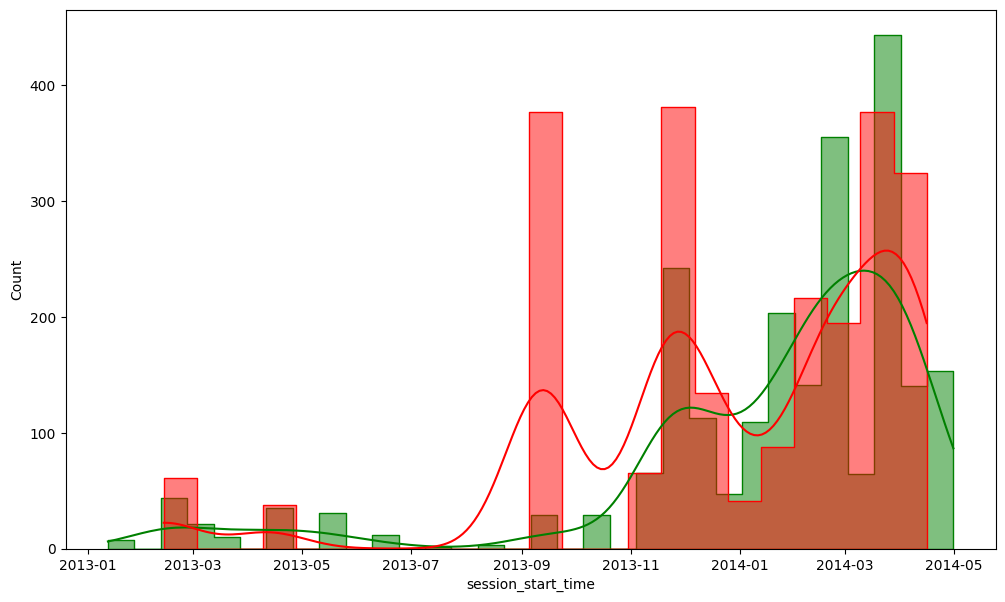

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_time', ax)

### session_end_time
The session_end_time feature, like the session_start_time, exhibits a similar distribution across both the target user (Alice) and the general user population. As such, it may not provide significant discriminative value in distinguishing Alice from other users based solely on this temporal attribute. The overlap in session end times suggests that this feature, on its own, is unlikely to be a strong indicator for user identification.

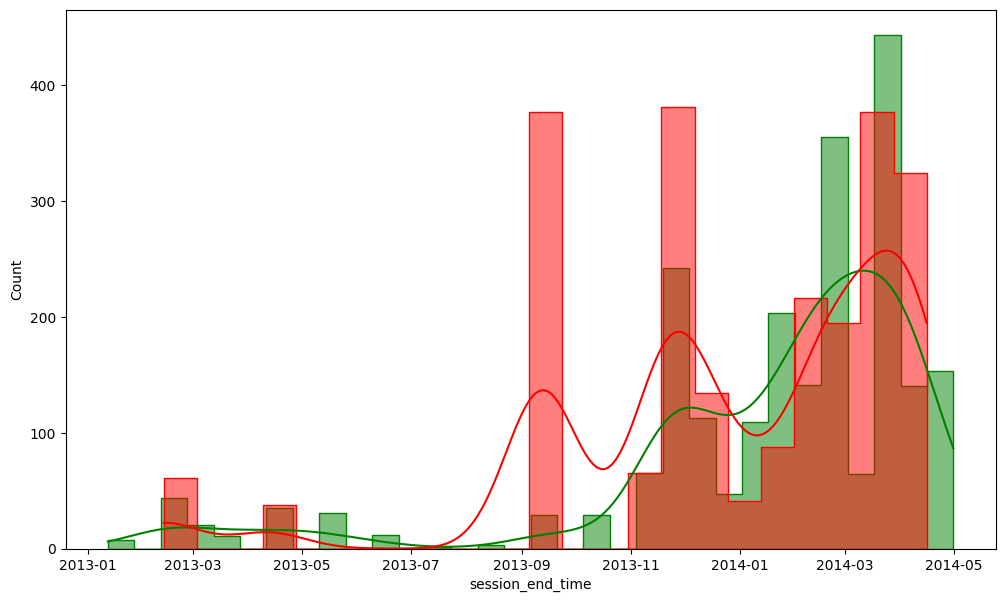

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_end_time', ax)

### session_length
Upon visualizing the data through histograms and box plots for both Alice and non-Alice users, a notable difference emerges in the box plot. While the histogram did not reveal clear distinctions, the box plot suggests that the session duration for Alice tends to be shorter compared to that of typical users. This difference in session lengths may offer valuable insights into Alice's behavior, warranting further exploration and potential inclusion as a discriminative feature in the analysis.

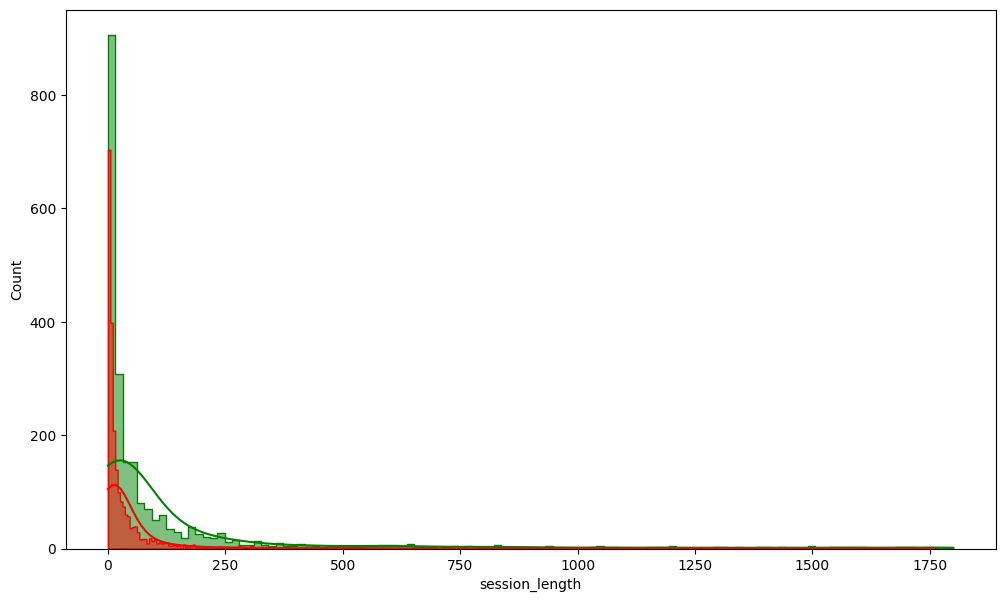

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_length', ax)

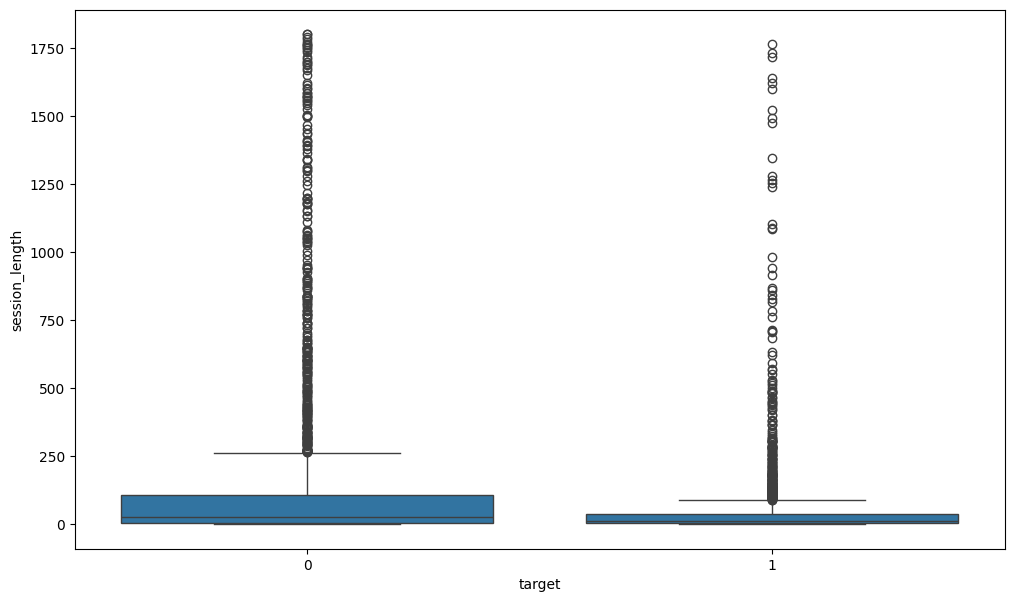

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_length', ax)

### session_start_year
The analysis of the session_start_year reveals that there is little to no significant difference between the sessions initiated by Alice and those of non-Alice users. This suggests that the year of session start does not provide a strong discriminative feature for identifying Alice, as the sessions appear to be distributed similarly across years.

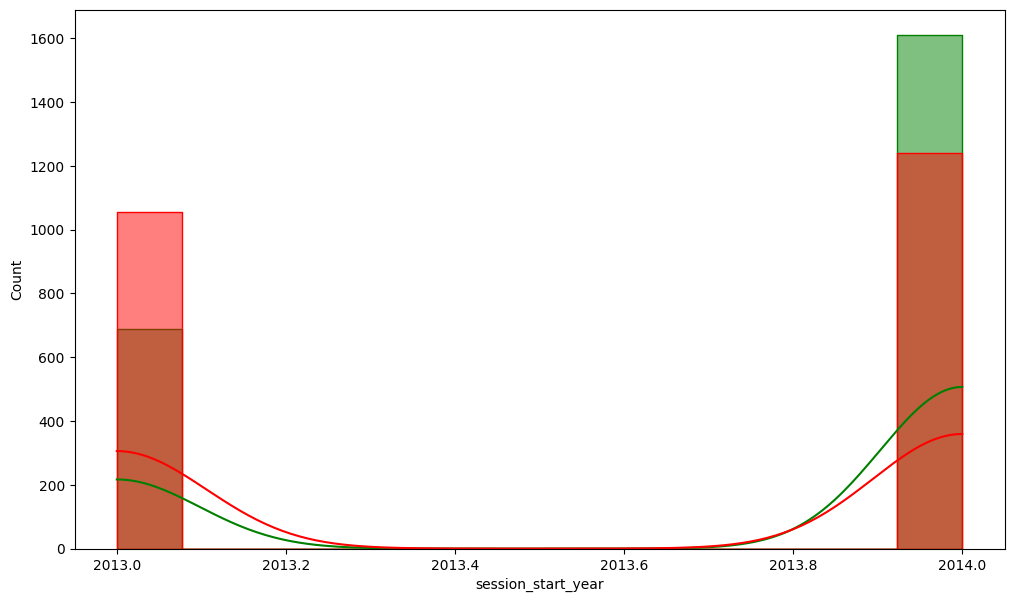

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_year', ax)

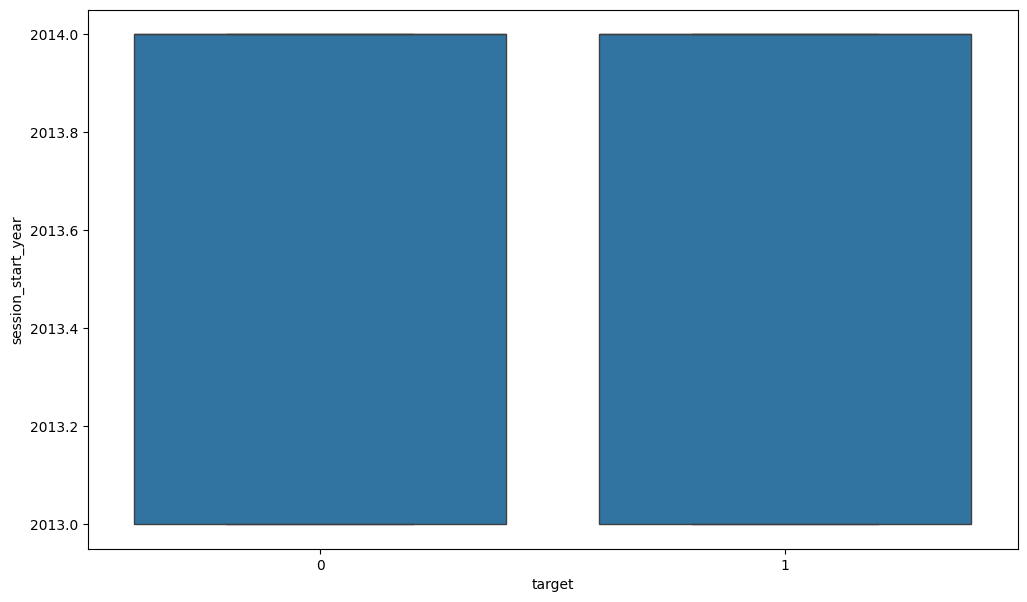

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_year', ax)

### session_start_month
The analysis of session_start_month indicates that Alice users tend to exhibit more activity during the months of September to December compared to other users. This suggests that Alice's behavior may have a seasonal pattern, with increased activity in the latter part of the year.

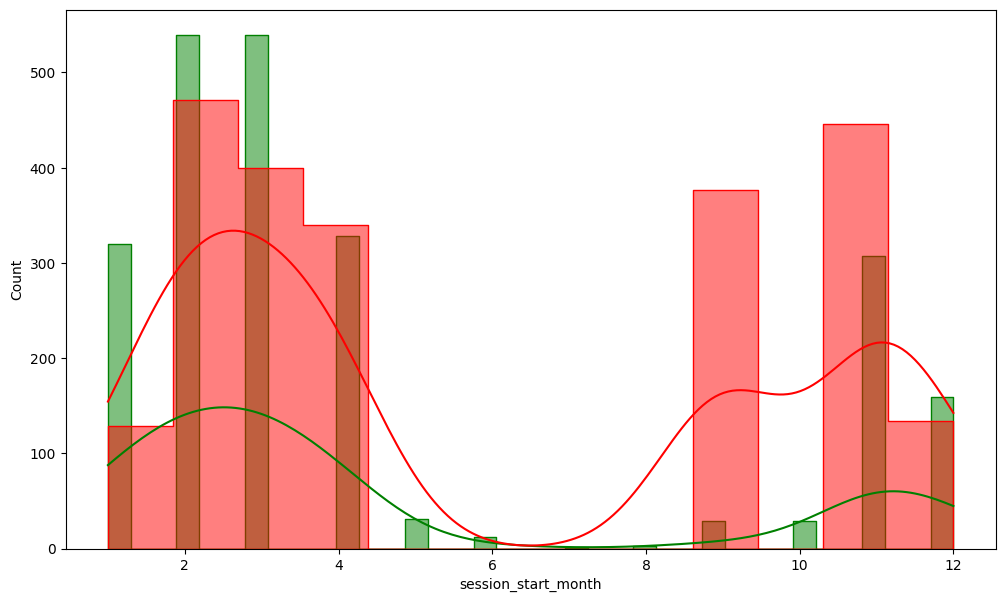

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_month', ax)

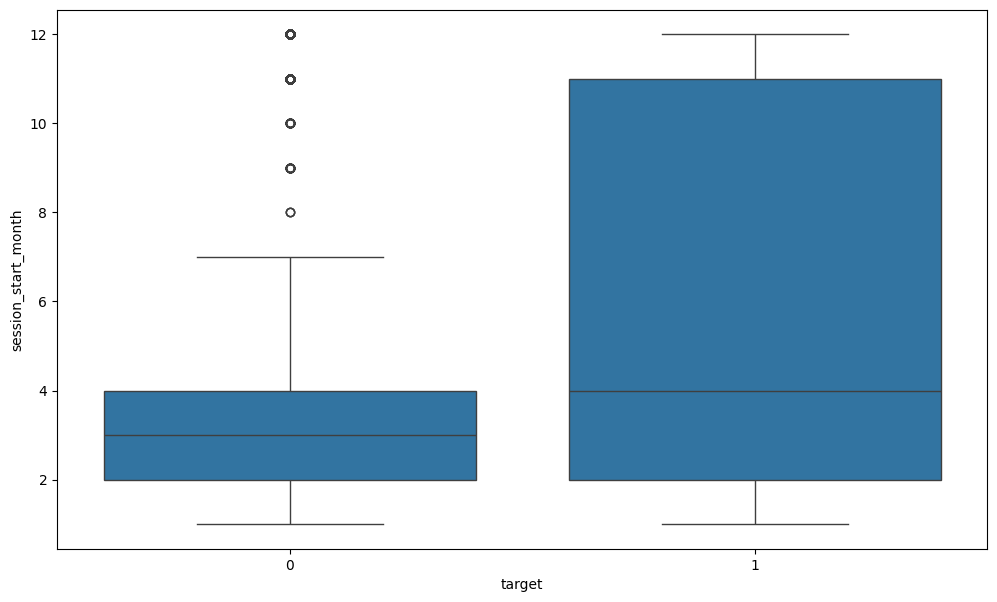

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_month', ax)

### session_start_day
No significant differences were observed in the session start day. Although some spikes were detected, the boxplot analysis reveals that these differences are not substantial.

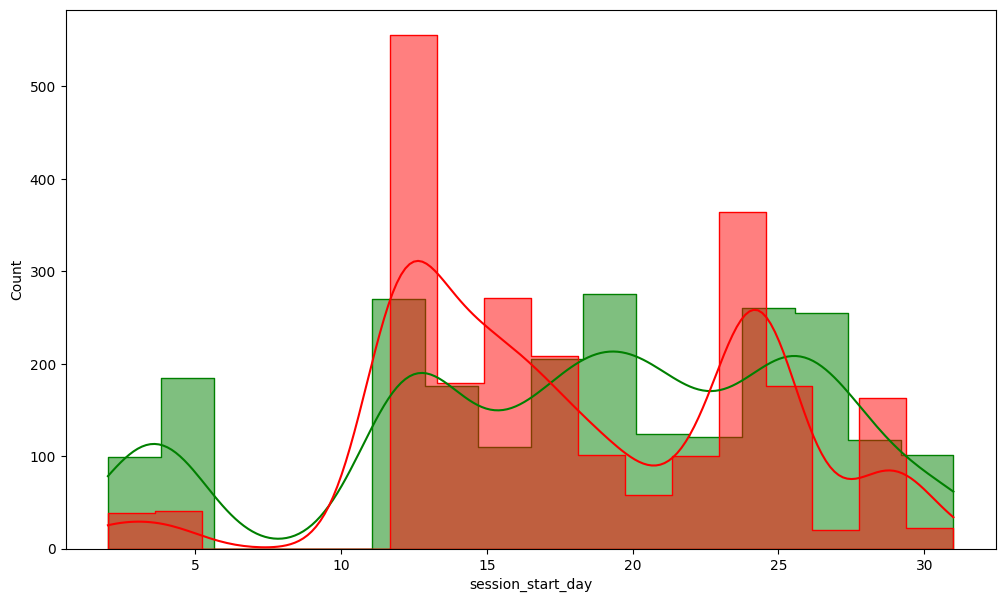

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_day', ax)

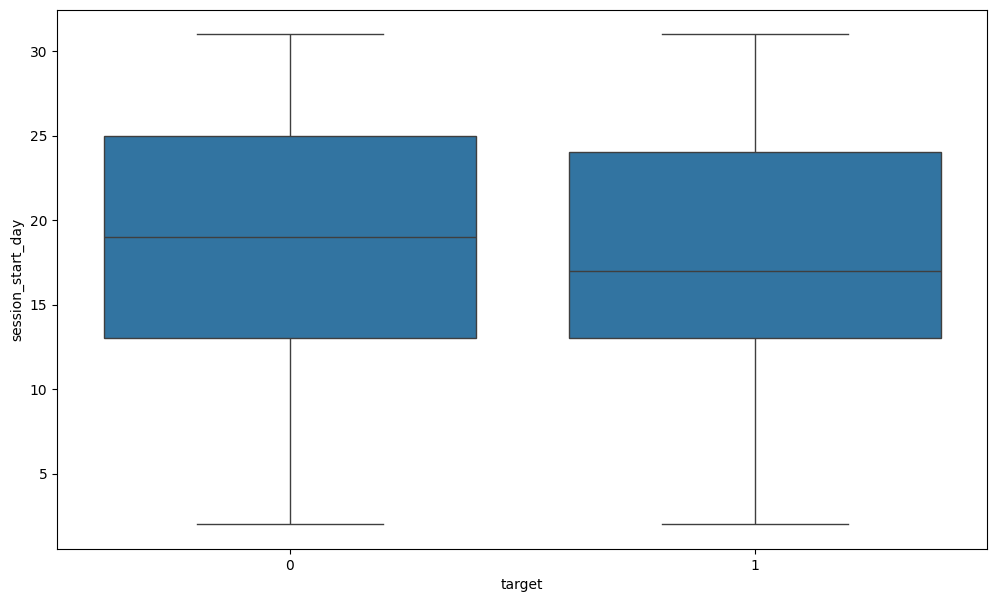

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_day', ax)

### session_start_hour
The session start times appear to be concentrated around 12:00, as well as between 16:00 and 18:00.

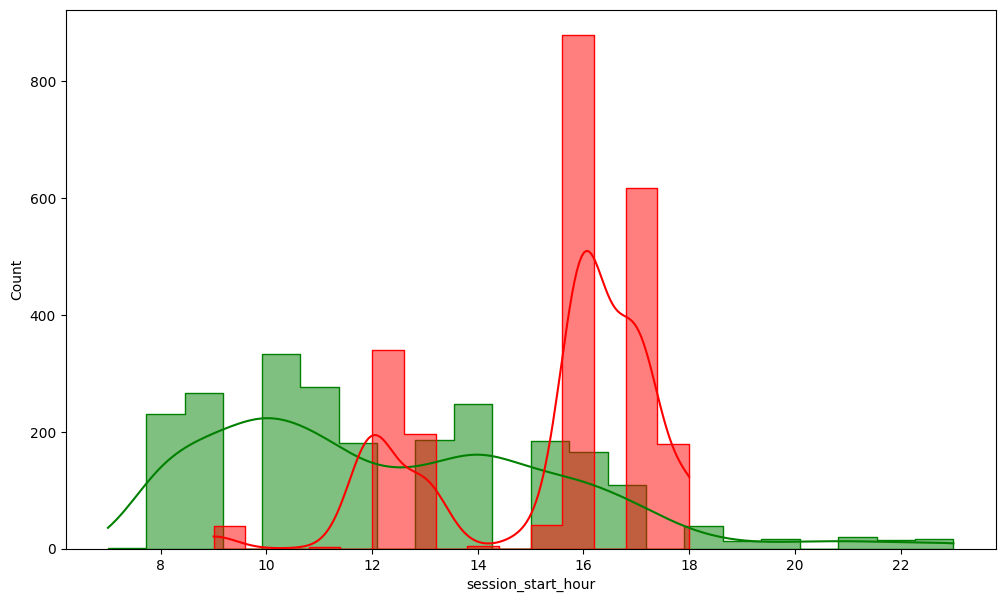

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_hour', ax)

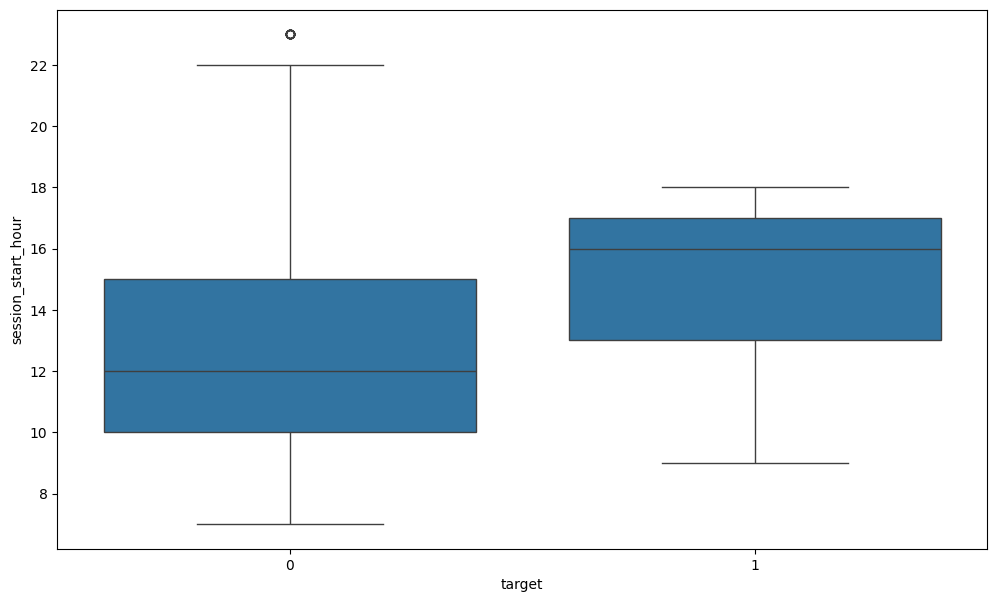

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_hour', ax)

### session_start_minute
No significant differences are observed, suggesting that there is no specific minute when activity tends to occur more frequently.

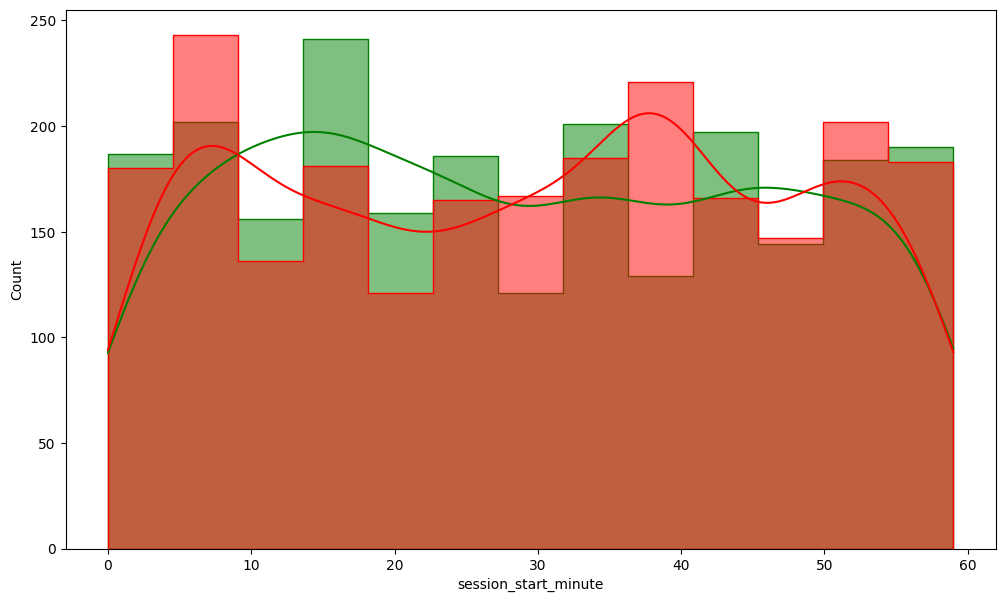

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_minute', ax)

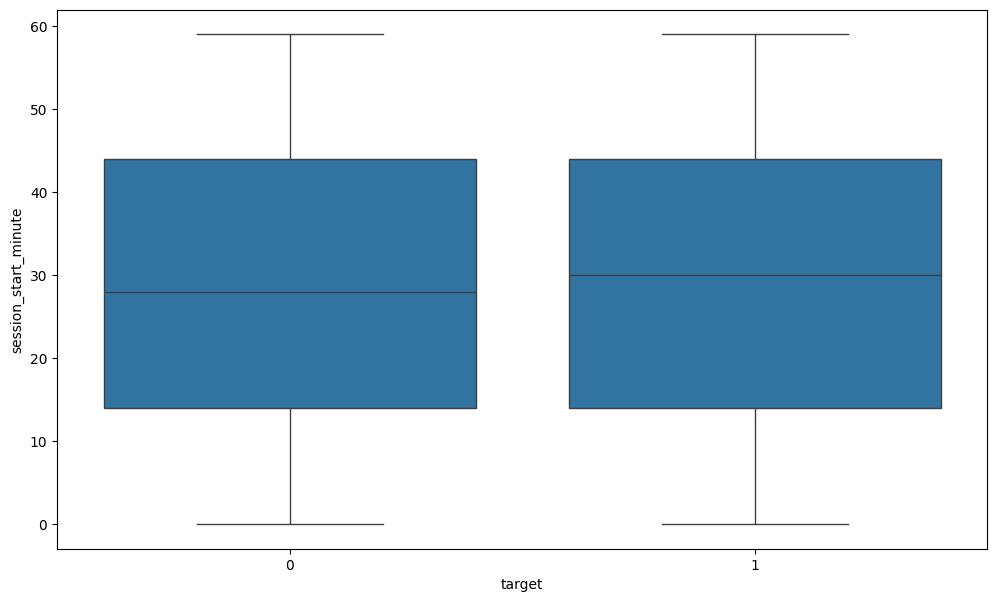

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_minute', ax)

### session_start_second
No significant differences are observed, indicating that there is no specific second when activity is more concentrated.

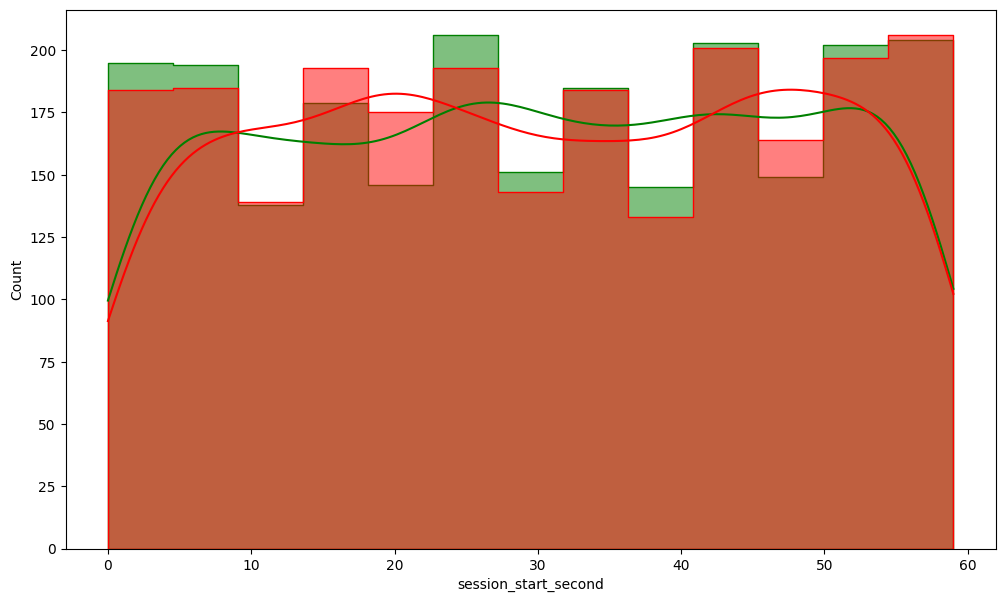

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_second', ax)

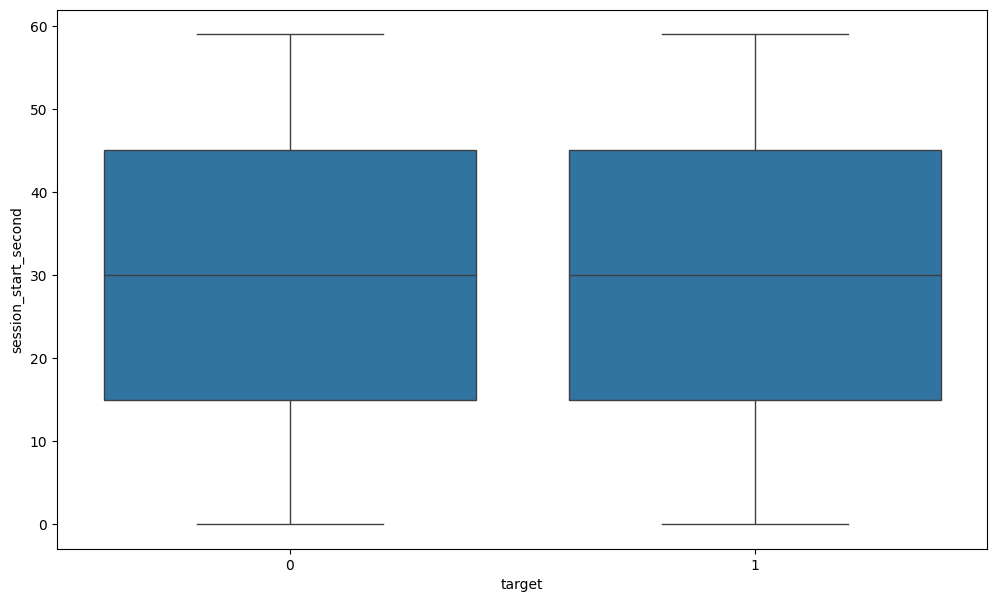

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_second', ax)

### session_start_weekday
It appears that Alice tends to be more active on specific weekdays. In particular, there is less activity on weekends.

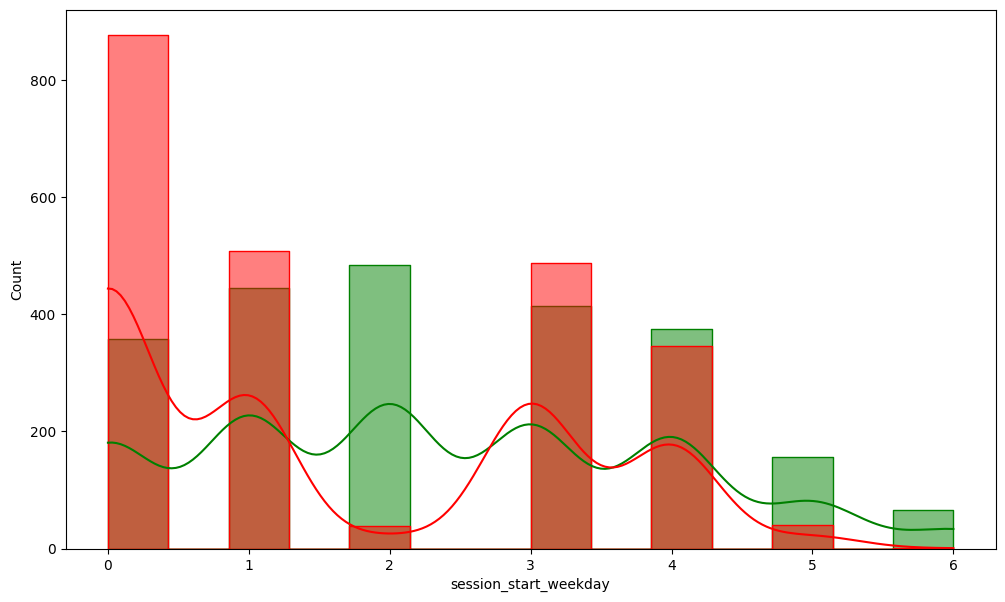

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('session_start_weekday', ax)

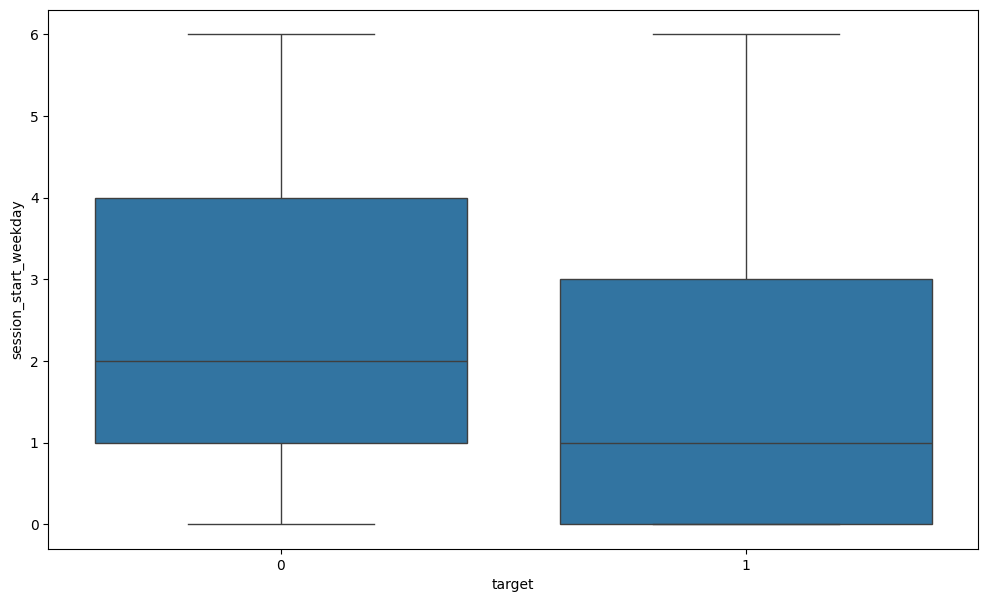

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('session_start_weekday', ax)

### is_weekend
This feature does not seem to be particularly useful as a distinguishing factor.

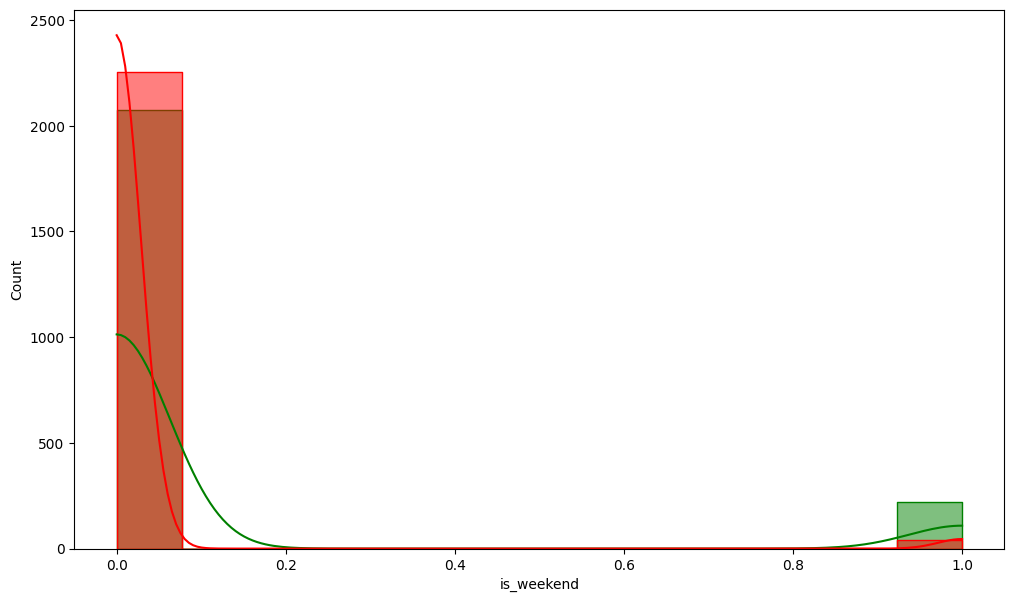

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_weekend', ax)

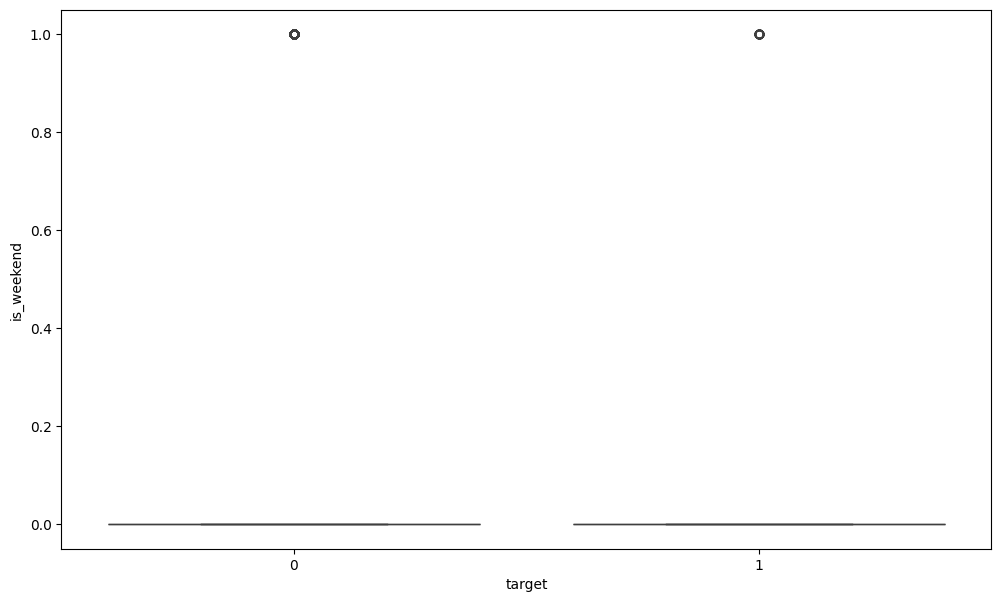

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_weekend', ax)

### is_midnight_activity
No activity was observed during midnight.

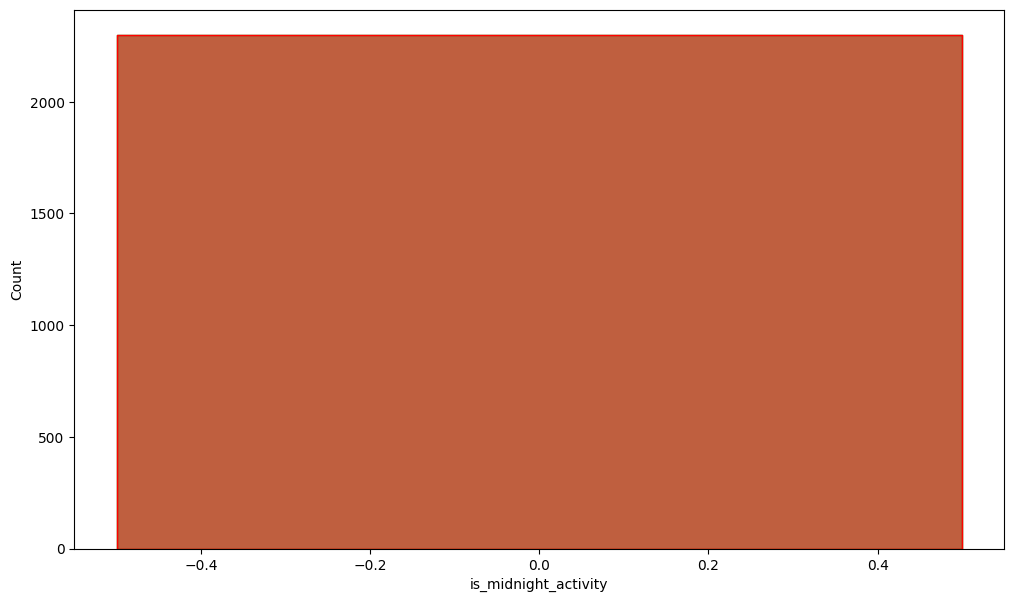

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_midnight_activity', ax)

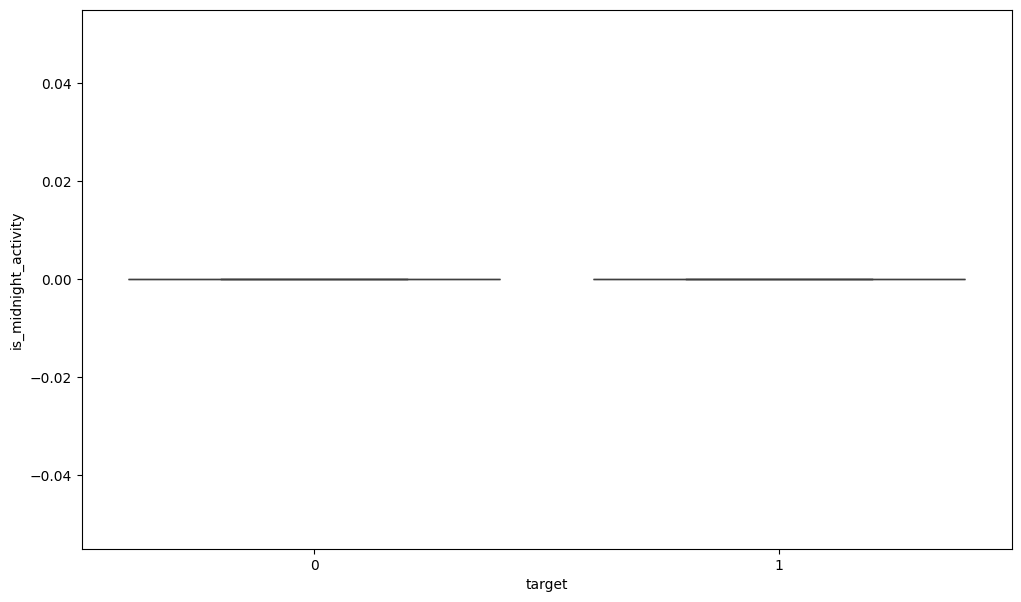

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_midnight_activity', ax)

### is_morning_activity
It is observed that Alice rarely engages in activity during the morning hours.

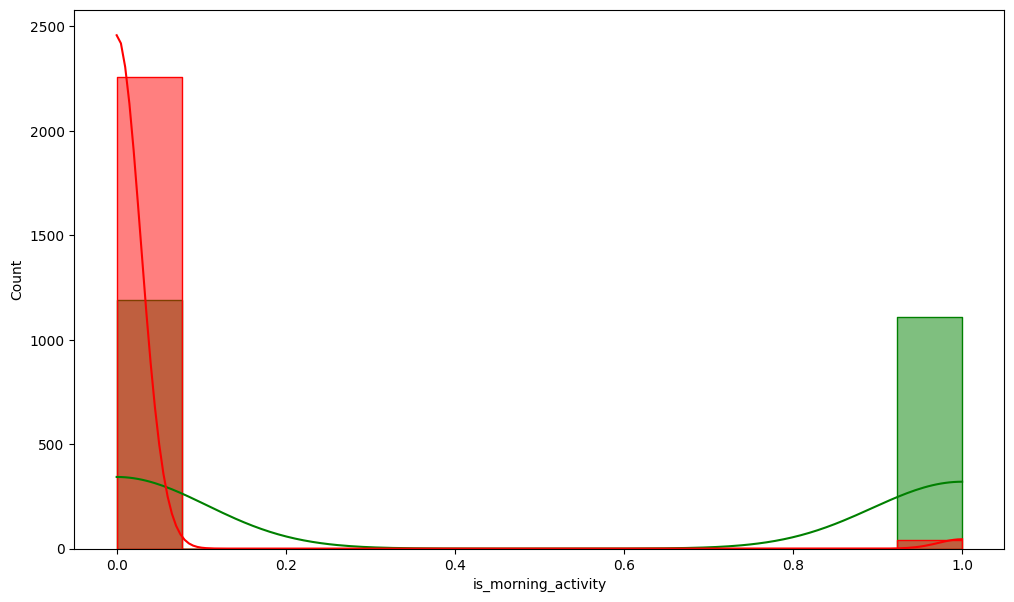

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_morning_activity', ax)

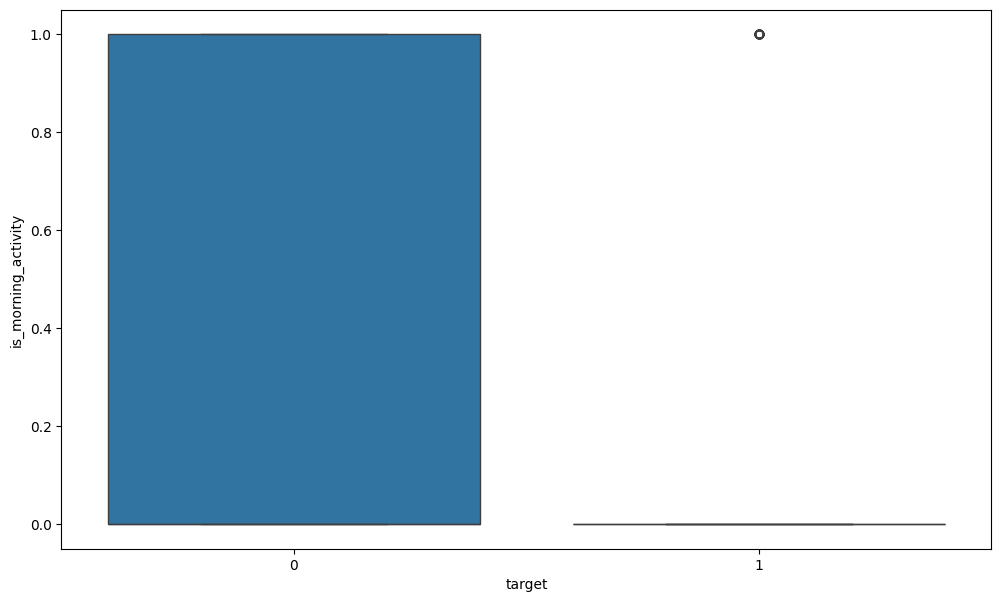

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_morning_activity', ax)

### is_midday_activity
It is evident that most of Alice's activities occur during midday.

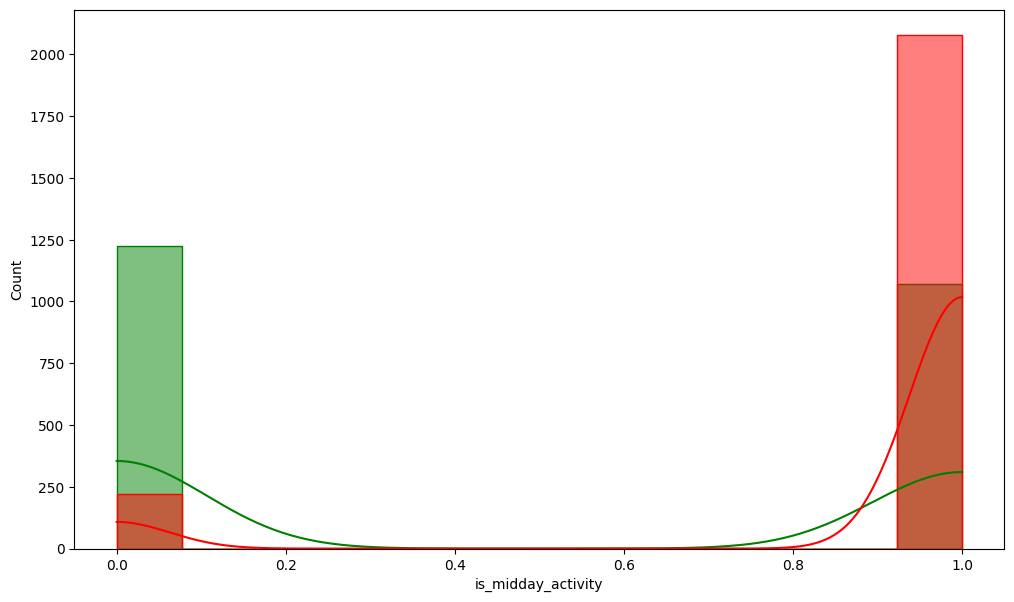

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_midday_activity', ax)

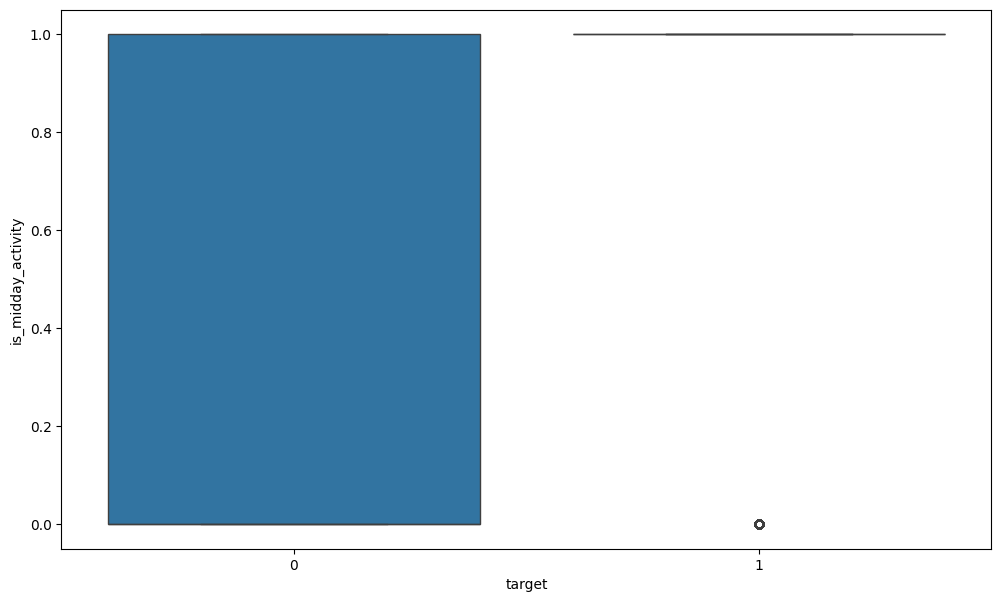

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_midday_activity', ax)

### is_evening_activity
Evening activities are relatively sparse for both Alice and other users.

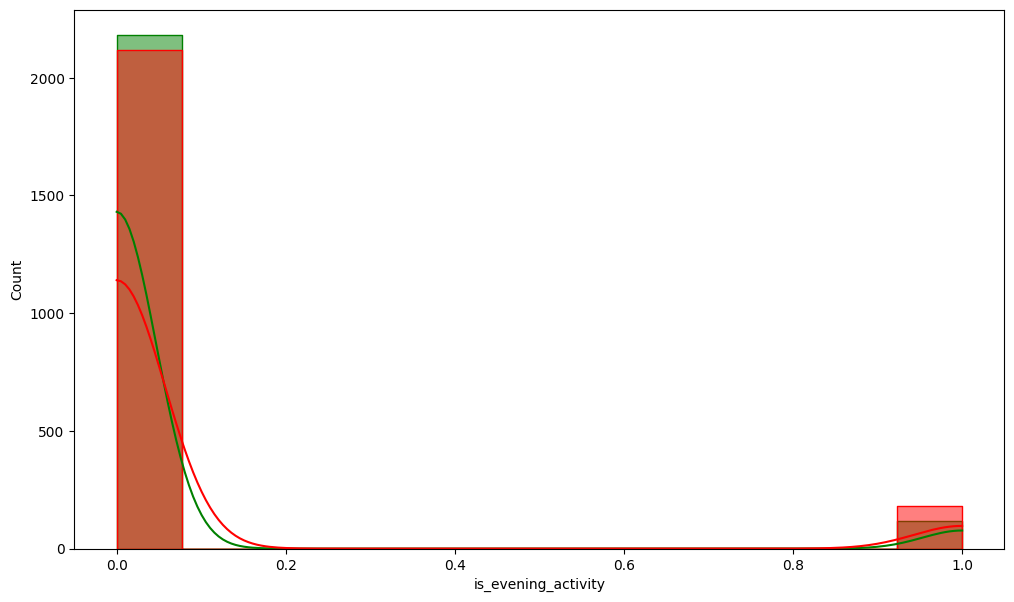

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_evening_activity', ax)

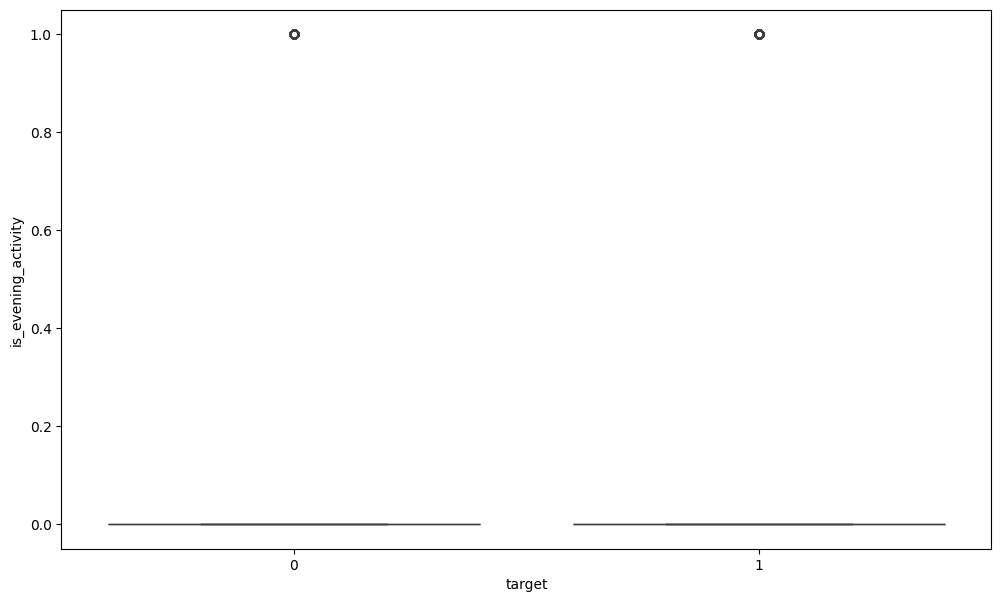

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_evening_activity', ax)

### is_month_start
There seems to be little difference in activity between Alice and other users on the start of the month.

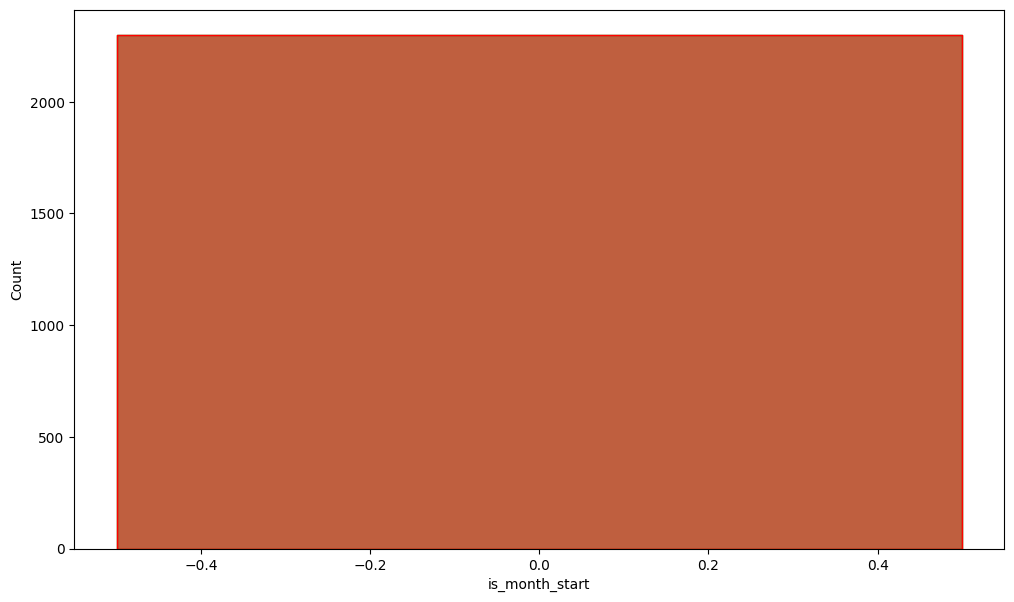

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_month_start', ax)

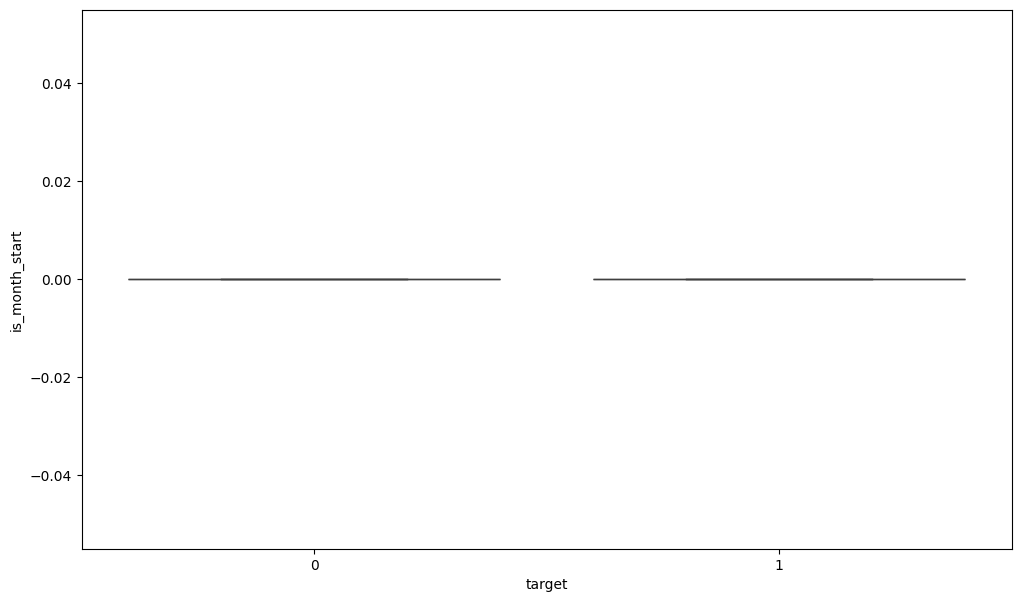

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_month_start', ax)

### is_month_end
Being the end of the month also does not appear to have much relevance.

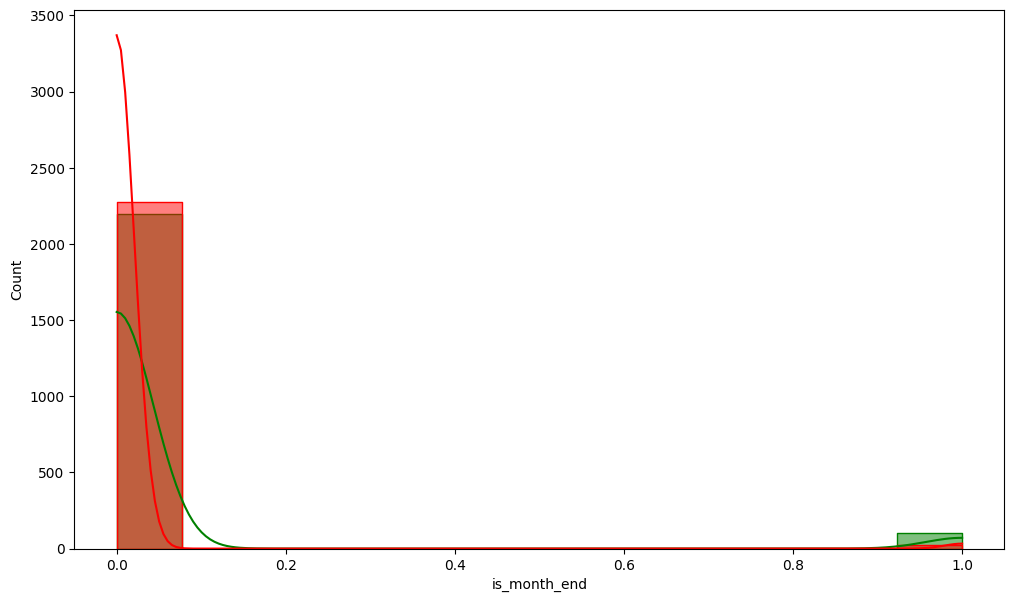

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_month_end', ax)

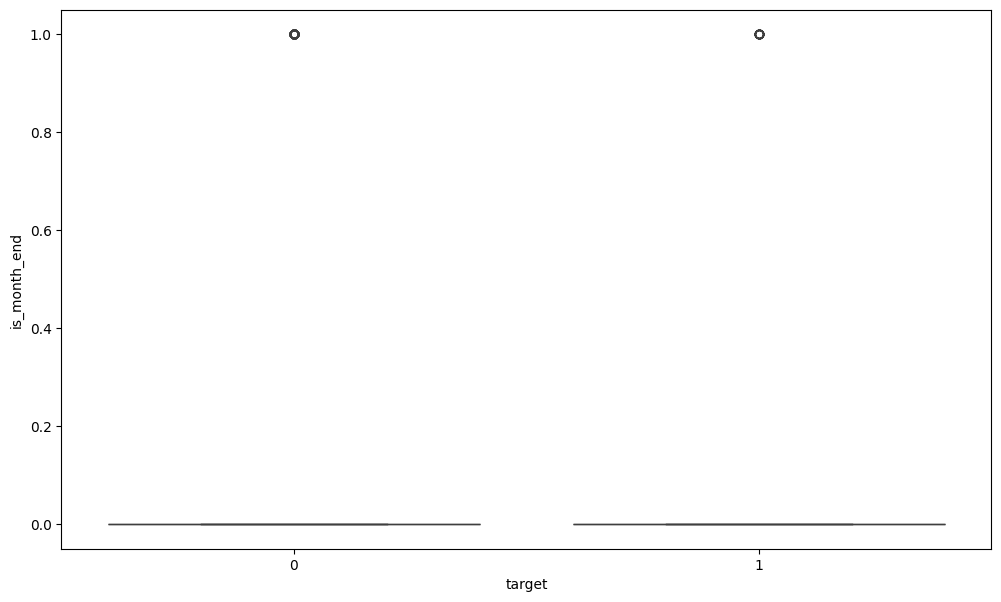

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_month_end', ax)

### is_quater_start
Whether it is the start of the quarter does not seem to have any significant relevance either.

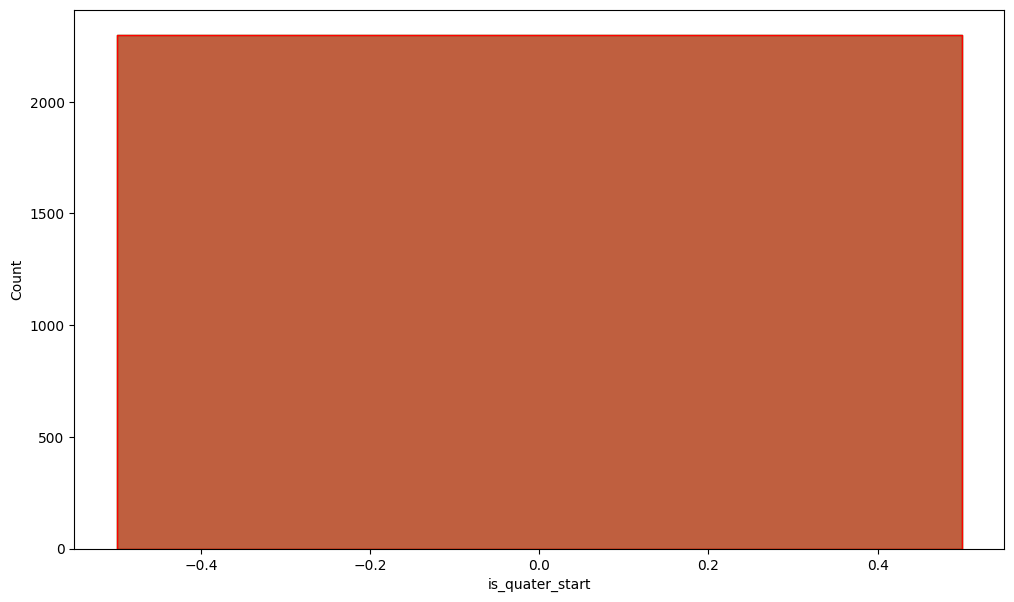

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_quater_start', ax)

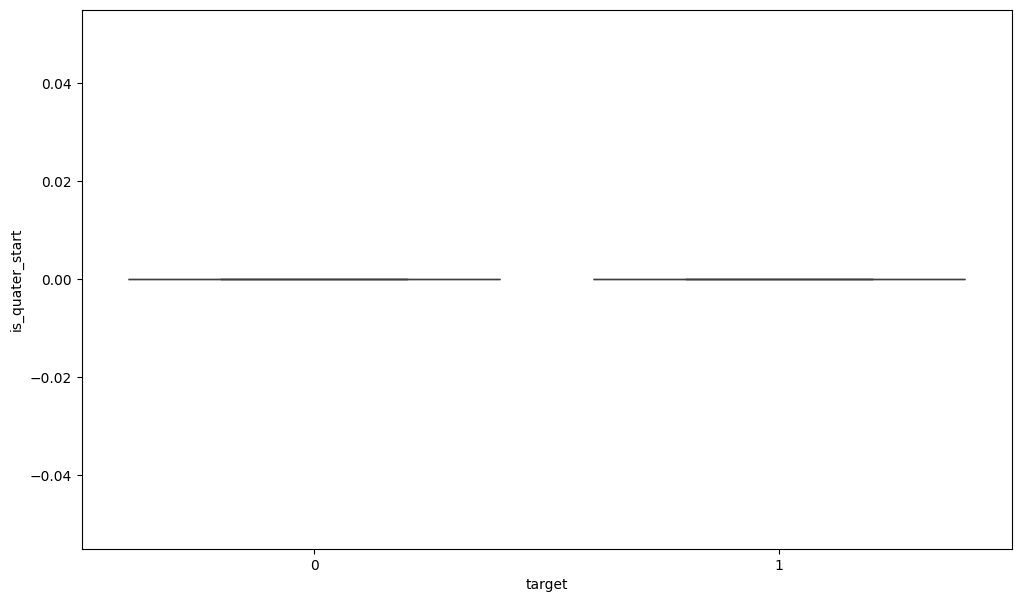

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_quater_start', ax)

### is_quater_end
Whether it is the end of the quarter also does not appear to be relevant.

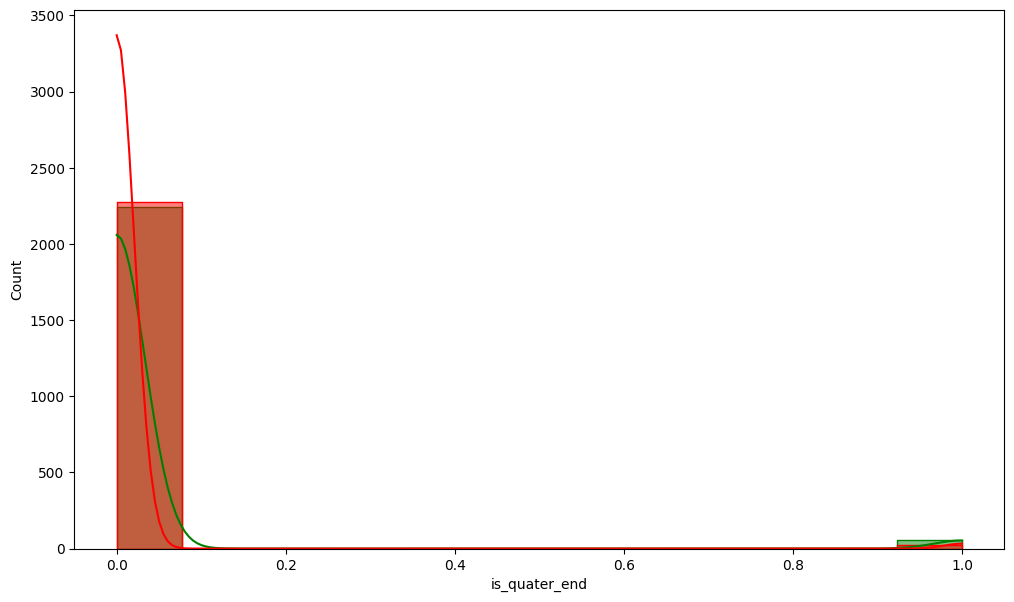

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_quater_end', ax)

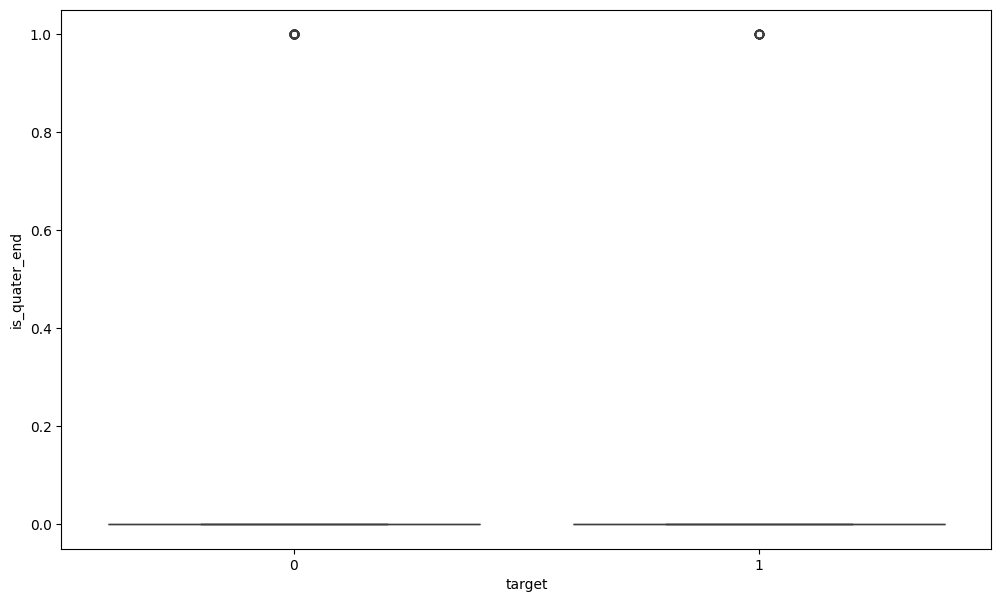

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_quater_end', ax)

### is_year_start
Whether it is the start of the year also does not appear to be relevant.

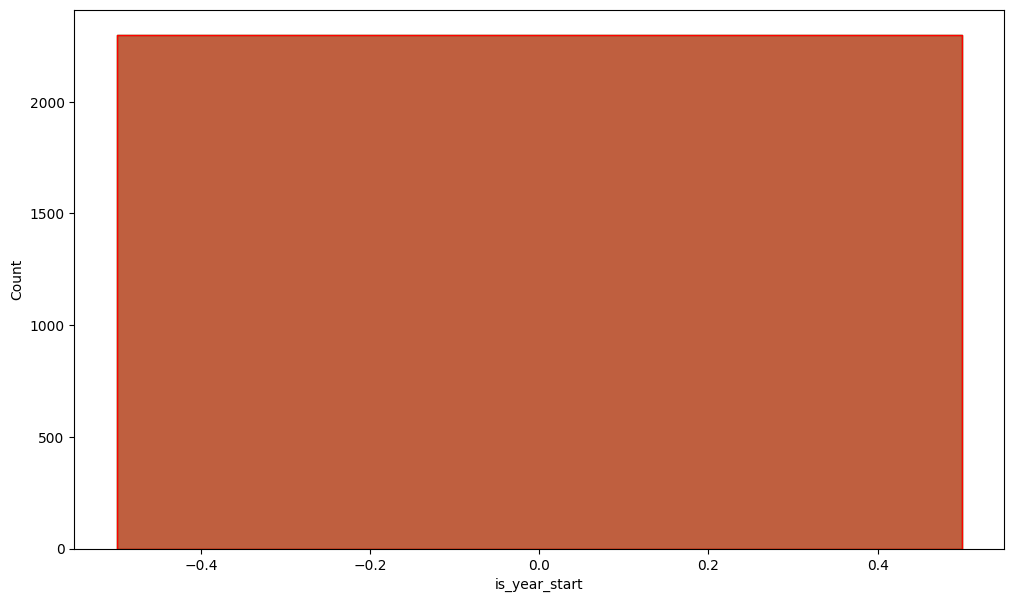

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_year_start', ax)

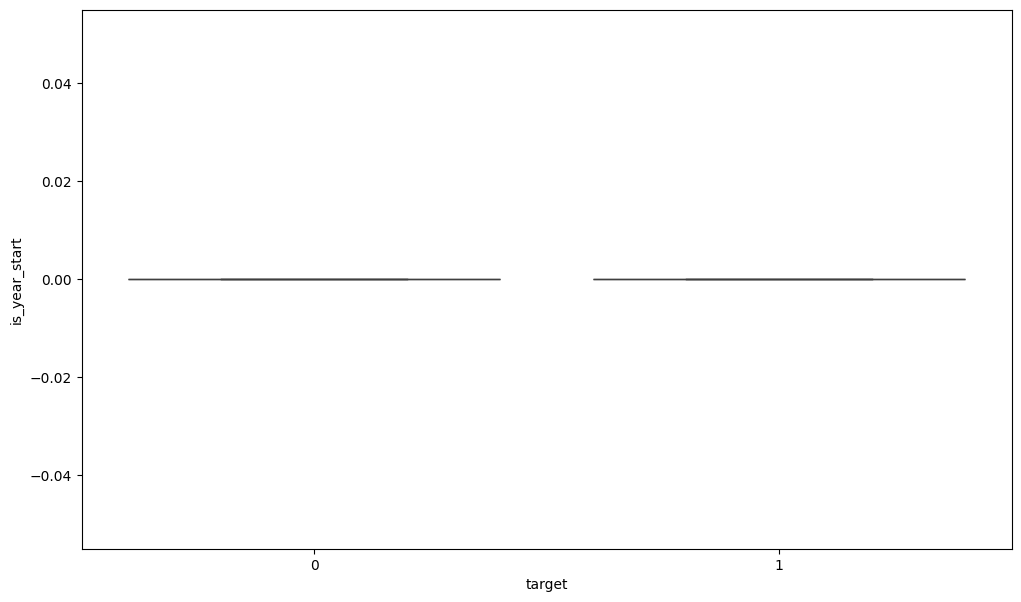

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_year_start', ax)

### is_year_end
Whether it is the end of the year also does not seem to be relevant.

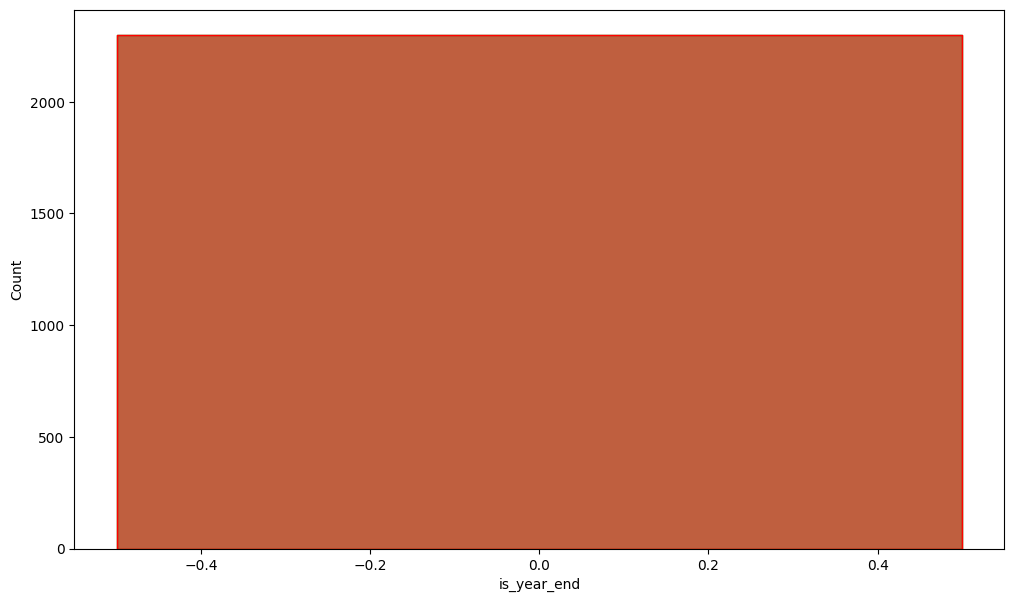

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_hist('is_year_end', ax)

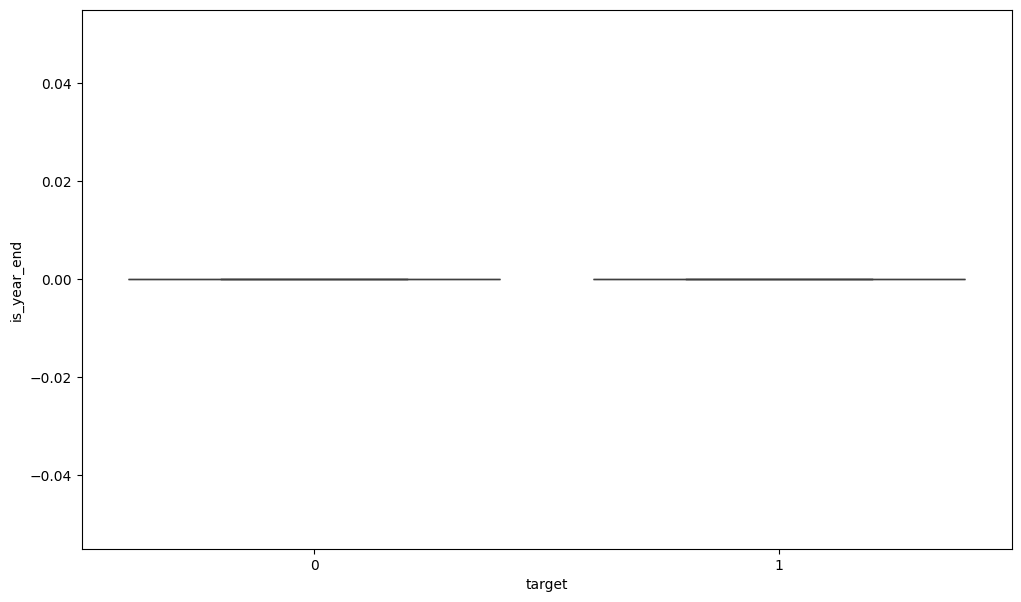

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_time.plot_boxplot('is_year_end', ax)

## 2.3 Site Operation
Each session includes access to at least one site, with a maximum of ten sites. This enables the identification of the sites a user interacts with. Features are derived based on the number of sites accessed by the user and the Fully Qualified Domain Names (FQDNs) associated with those sites. The generated features are as follows:

| Feature                  | Description                                      |
|--------------------------|--------------------------------------------------|
| **number of sites**       | The number of sites accessed during the session.           |
| **avg_domain_name_length**| The average length of Fully Qualified Domain Names (FQDNs).                               |
| **mode_tld**              | 	The most frequent top-level domain (TLD) in the accessed sites.                                      |
| **mode_domain**           | The most frequent domain in the accessed sites.                                   |

In [52]:
# site operation
def site_operations(dataset, site_dictionary):
    # get top level domain
    def get_tld(fqdn):
        ext = tldextract.extract(fqdn)
        tld = ext.suffix
        return tld
    
    # get domain name
    def get_domain_name(fqdn):
        ext = tldextract.extract(fqdn)
        domain = ext.domain
        return domain

    df = dataset.copy()

    # count sites
    df['number_of_sites'] = df[[f'site{i+1}' for i in range(10)]].notna().sum(axis=1)

    reversed_dict = {v: k for k, v in site_dictionary.items()}
    # replace site id with site name and compute domain name length
    for col in [f"site{i}" for i in range(1,11)]:
        df[f'{col}_name'] = df[col].map(reversed_dict)
        df[f'{col}_name_length'] = df[f'{col}_name'].fillna('').apply(len)

        # top level domain
        df[f'{col}_tld'] = df[f'{col}_name'].fillna('').apply(get_tld)
        df[f'{col}_tld'] = df[f'{col}_tld'].astype('category')

        # domain name
        df[f'{col}_domain_name'] = df[f'{col}_name'].fillna('').apply(get_domain_name)
        df[f'{col}_domain_name'] = df[f'{col}_domain_name'].astype('category')

    # average domain_name_length
    df['avg_domain_name_length'] = df[[f"site{i}_name_length" for i in range(1,11)]].mean(axis=1)

    # most frequent tld
    df['mode_tld'] = df[[f"site{i}_tld" for i in range(1,11)]].mode(axis=1)[0]
    df['mode_tld'] = df['mode_tld'].astype('category')

    # most frequent domain
    df['mode_domain'] = df[[f"site{i}_domain_name" for i in range(1,11)]].mode(axis=1)[0]
    df['mode_domain'] = df['mode_domain'].astype('category')
    return df


In [53]:
df_site = UserActivityRecord(site_operations(df_train, site_dic))

### number_of_sites
There is little to no difference between Alice and other users in terms of the number of sites accessed.

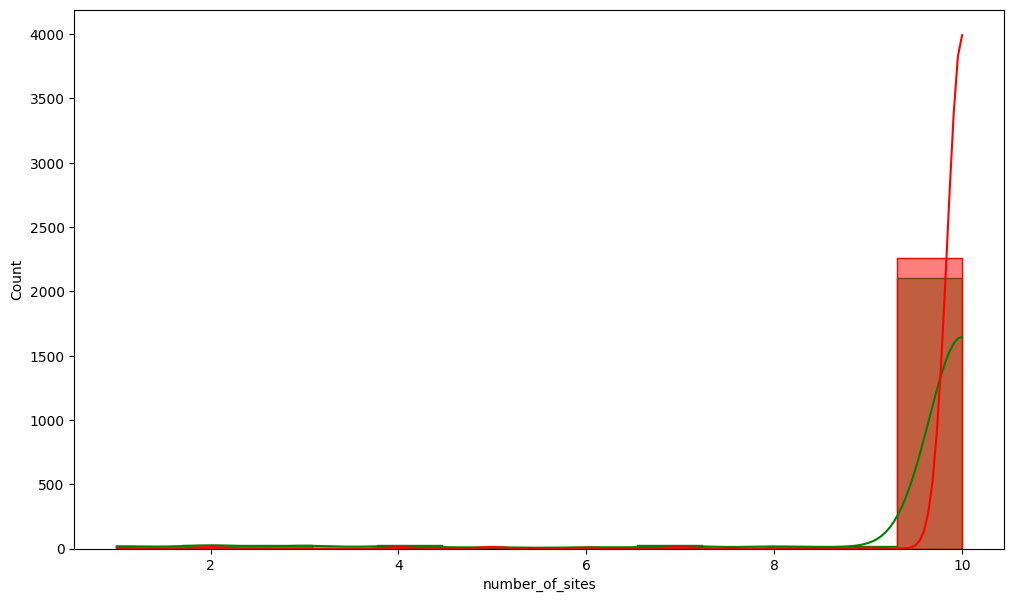

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_site.plot_hist('number_of_sites', ax)

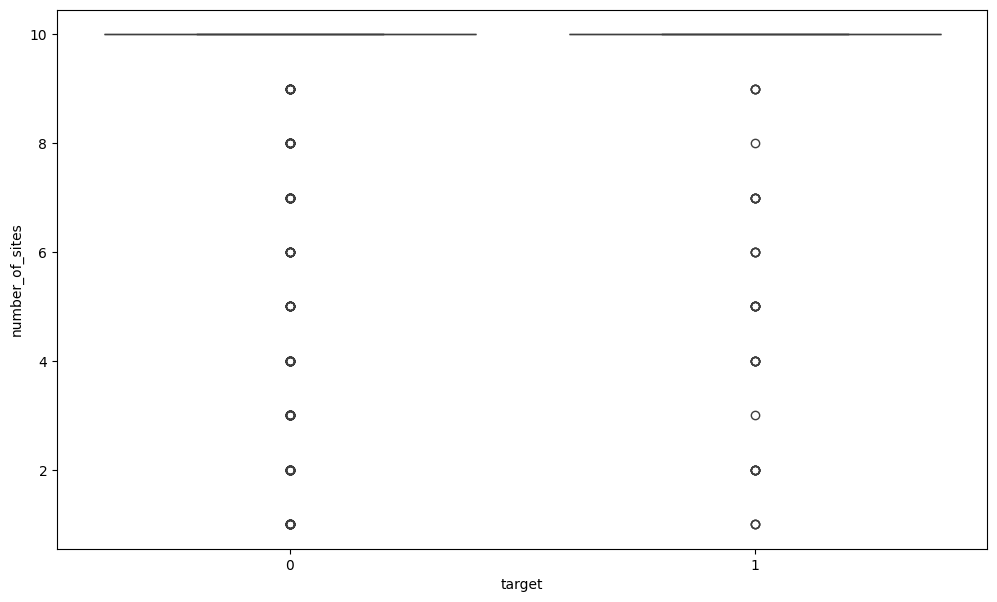

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_site.plot_boxplot('number_of_sites', ax)

### avg_domain_name_length
The average length of domain names does not appear to have a significant impact.

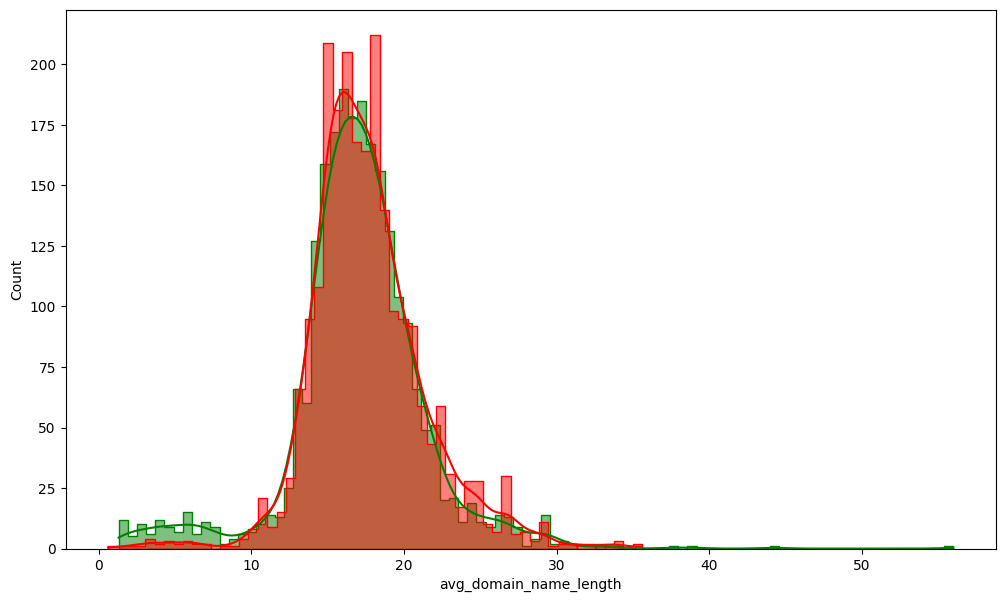

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_site.plot_hist('avg_domain_name_length', ax)

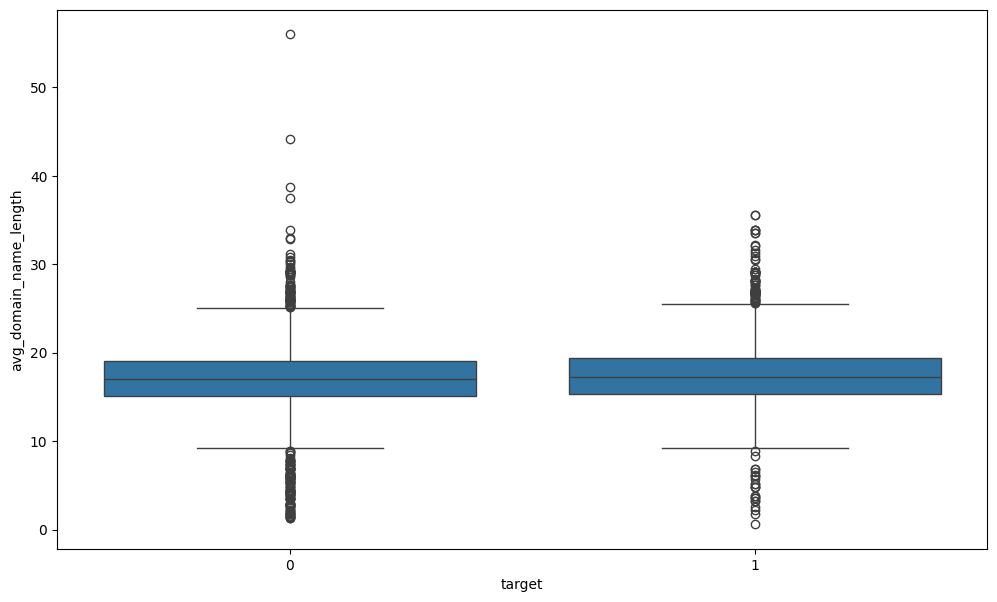

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_site.plot_boxplot('avg_domain_name_length', ax)

### mode_tld
An examination of the most frequent top-level domain (TLD) suggests that there is little to no distinguishable difference between the target user (Alice) and other users.

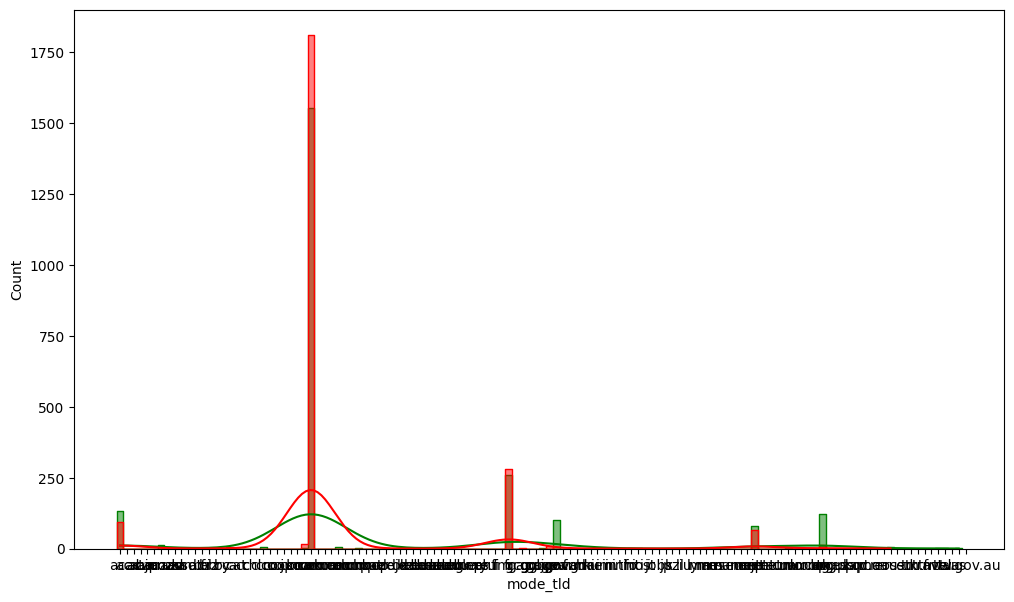

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_site.plot_hist('mode_tld', ax)

### mode_domain
The most frequently visited domain by Alice appears to be skewed toward specific domains, indicating a potential pattern or preference in her browsing behavior that could be leveraged for user identification.The most frequently visited domain by Alice appears to be skewed toward specific domains, indicating a potential pattern or preference in her browsing behavior that could be leveraged for user identification.

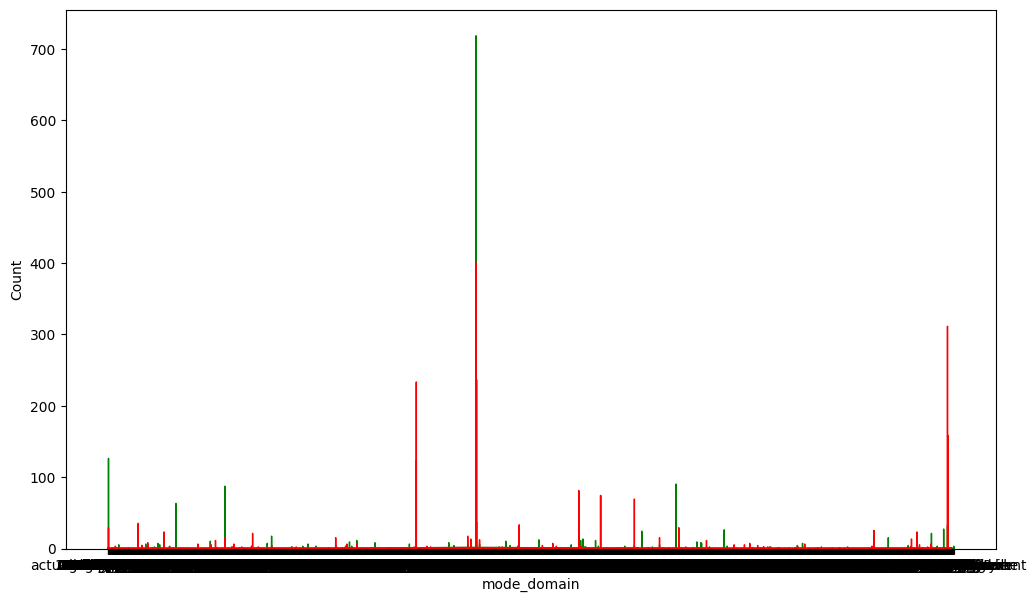

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_site.plot_hist('mode_domain', ax)

## 2.4 User Activity Operation
To capture user activity, we apply techniques from Sequential Pattern Mining to identify frequent browsing patterns specific to Alice. This approach enables the extraction of behavioral sequences that may distinguish Alice from other users. Additionally, we incorporate the most frequently visited websites by Alice as features, under the assumption that certain domains are indicative of her unique browsing habits.

### 2.4.1 User Sequential Pattern Mining
To model user activity, we apply Sequential Pattern Mining, a technique designed to discover frequent patterns from temporally ordered data. This method has been widely adopted in domains such as e-commerce purchase analysis, web clickstream mining, and network anomaly detection. Among various algorithms, we employ PrefixSpan (Prefix-projected Sequential Pattern Mining), which efficiently mines the frequent sequential patterns without candidate generation.

After learning recurrent access patterns from the target user, Alice, we construct a reference pattern database. We then evaluate each user session against this database to determine whether it matches any of Alice’s frequent behavioral patterns.

A binary feature, doubtful_alice_behaviour, is added to indicate whether a session aligns with these learned patterns (1 if matched, 0 otherwise).

In [60]:
# user activity
class UserActivity:
    def __init__(self, y = 'target', minSupport=0.01, maxPatternLength = 10):
        # initialize Spark session
        self.sc = SparkSession.builder.appName("prefix_span").getOrCreate()
        # create PrefixSpan instance
        self.prefix_span = PrefixSpan(minSupport=minSupport, maxPatternLength=maxPatternLength)
        self.y = y

    def create_column(self, pd_dataframe, create_column = 'user_activity'):
        pd_df = pd_dataframe.copy()
        # create columns for computing 
        sites = pd_df[[f"site{i}" for i in range(1,11)]].values.tolist()
        pd_df[create_column] = [[ [int(x)] for x in site if not pd.isna(x)] for site in sites]
        return pd_df

    def createDataFrame(self, pd_dataframe, create_column = 'user_activity'):
        pd_df = pd_dataframe.copy()
        pd_df = self.create_column(pd_dataframe, create_column)

        # get only Alice user
        pd_target_user = pd_df[pd_df[self.y] == 1]

        # create spark dataframe
        original_sequences = [(site_row,) for site_row in pd_target_user[create_column]]
        spark_dataframe = self.sc.createDataFrame(original_sequences, ['sequence'])
        return spark_dataframe

    def build(self, spark_dataframe):
        # find sequential patterns
        self.model = self.prefix_span.findFrequentSequentialPatterns(spark_dataframe)
        # set sequence list
        self.sequence_list = [[item for item in inner_list.sequence] for inner_list in self.model.collect()]

    def show_model(self):
        show model
        self.model.sort("freq", ascending=False).show(truncate=False)

    def has_pattern(self, x):
        # find the sequence
        def is_sublist_match(list1, list2):
            for i in range(len(list1) - len(list2) + 1):
                if list1[i:i+len(list2)] == list2:
                    return True
            return False
        return any(is_sublist_match(x, inner_list) for inner_list in self.sequence_list)

In [61]:
activity = UserActivity(minSupport=0.01, maxPatternLength = 10)
spark_dataframe = activity.createDataFrame(df_train[df_train.target == 1])
activity.build(spark_dataframe)
activity.show_model()

+------------+----+
|sequence    |freq|
+------------+----+
|[[76]]      |706 |
|[[77]]      |667 |
|[[80]]      |647 |
|[[29]]      |572 |
|[[76], [77]]|444 |
|[[22]]      |415 |
|[[77], [76]]|414 |
|[[77], [77]]|407 |
|[[76], [76]]|394 |
|[[80], [76]]|390 |
|[[80], [77]]|365 |
|[[21]]      |364 |
|[[76], [80]]|362 |
|[[77], [80]]|353 |
|[[80], [80]]|348 |
|[[23]]      |342 |
|[[35]]      |340 |
|[[75]]      |301 |
|[[33]]      |271 |
|[[81]]      |238 |
+------------+----+
only showing top 20 rows



### 2.4.2 User visit site
The dataset is initially structured in a wide format, with each session_id associated with up to ten site entries (site1 to site10). To facilitate sequential pattern analysis and feature engineering, we transform this wide-format data into a long format, where each row represents a unique pair of session_id and site, along with the corresponding target label indicating whether the session belongs to Alice.

After the transformation, we compute the mean of the target variable for each site to estimate the frequency with which Alice visits individual sites. This analysis reveals that Alice has not accessed the vast majority of sites in the dataset.

However, among the sites she does visit, certain domains are accessed with noticeably high frequency. Based on this observation, we introduce a threshold to identify these frequently visited sites. We then construct a binary feature that indicates whether a given session includes access to any of these high-frequency sites, capturing a key aspect of Alice’s browsing behavior.

In [62]:
def regularize_records(dataset):
    df = dataset.copy()
    # create data session id, site, target columns
    df_list = []
    for j in range(1, 11):
        df_temp = df[['session_id', f'site{j}', 'target']].copy()
        df_temp.columns = ['session_id', 'site', 'target']
        df_list.append(df_temp)

    df = pd.concat(df_list, ignore_index=True)

    # group by site and target mean.
    sites = df.groupby('site')['target'].mean()
    pd.DataFrame(sites).sort_values('target')
    return sites

sites = regularize_records(df_train)

# check the site
print(f'Other user visit site fractions: {len(sites[sites == 0])/len(sites)}')

Other user visit site fractions: 0.9746881084589313


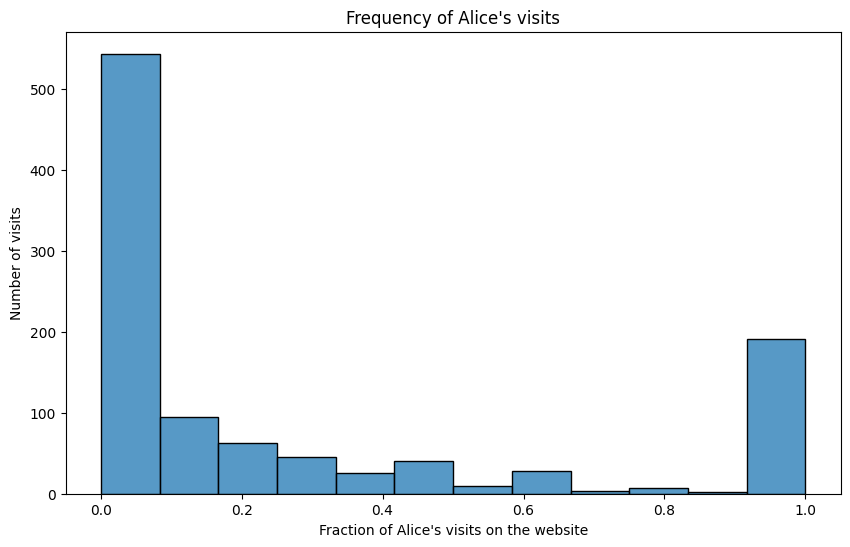

In [63]:
ax, fig = plt.subplots(figsize=(10,6))
sns.histplot(data=pd.DataFrame(sites[sites > 0]), x = 'target')
plt.title("Frequency of Alice's visits" )
plt.xlabel("Fraction of Alice's visits on the website")
plt.ylabel("Number of visits")
plt.show()

In [64]:
# add feature about alice's frequesntly visiting site 
def add_alice_site(dataframe, sites, threshold, column_name):
    df = dataframe.copy()
    mask = sites[sites > threshold].index
    df[column_name] = 0
    for col in [f"site{i}" for i in range(1,11)]:
        alice_mask = df[col].isin(mask)
        df.loc[alice_mask, column_name] = 1
    return df

# take thresholds to create corresponding features.
def add_alice_sites(dataframe, sites, thresholds = [0.01, 0.05, 0.1, 0.3, 0.5]):
    df = dataframe.copy()
    count = 1
    for threshold in thresholds:
        df = add_alice_site(df, sites, threshold, column_name=f'alice_site_{count}')
        count += 1
    return df

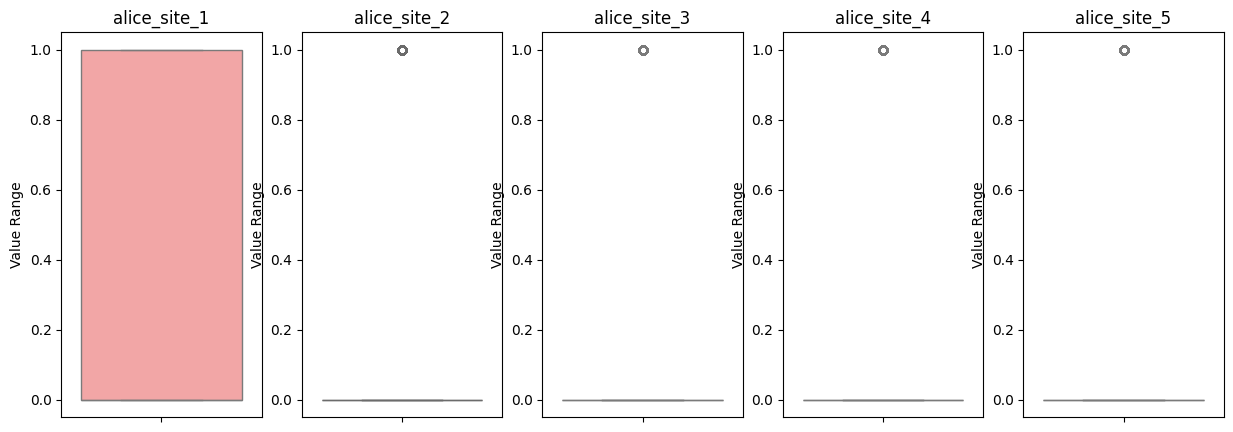

In [65]:
def plot_alice_sites(dataframe):
    df = dataframe.copy()
    thresholds = [0.01, 0.05, 0.1, 0.3, 0.5]
    sites = regularize_records(df)
    plot_data = add_alice_sites(df, sites, thresholds)

    features = [f'alice_site_{i}' for i in range(1, len(thresholds) + 1)]
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CCFF99']
    fig, axes = plt.subplots(1, len(thresholds), figsize=(15, 5))

    for ax, feature, color in zip(axes, features, colors):
        sns.boxplot(y=plot_data[feature], ax=ax, color=color)
        ax.set_title(feature)
        ax.set_ylabel("Value Range")

plot_alice_sites(df_train)

### 2.4.3 user_operation function

In [66]:
# user operation
def user_operation(dataset, activity):
    df = dataset.copy()

    df = activity.create_column(df)
    df['doubtful_alice_behaviour'] = df['user_activity'].apply(lambda x:activity.has_pattern(x)).astype(int)
    df = add_alice_sites(df, sites)
    return df

In [67]:
df_user = UserActivityRecord(user_operation(df_train, activity))

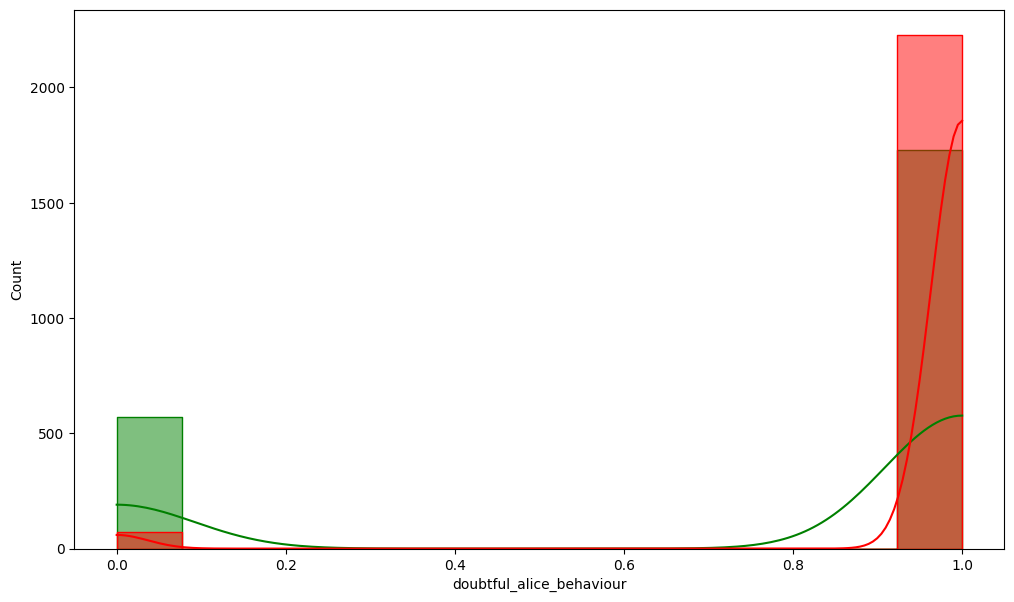

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_user.plot_hist('doubtful_alice_behaviour', ax)

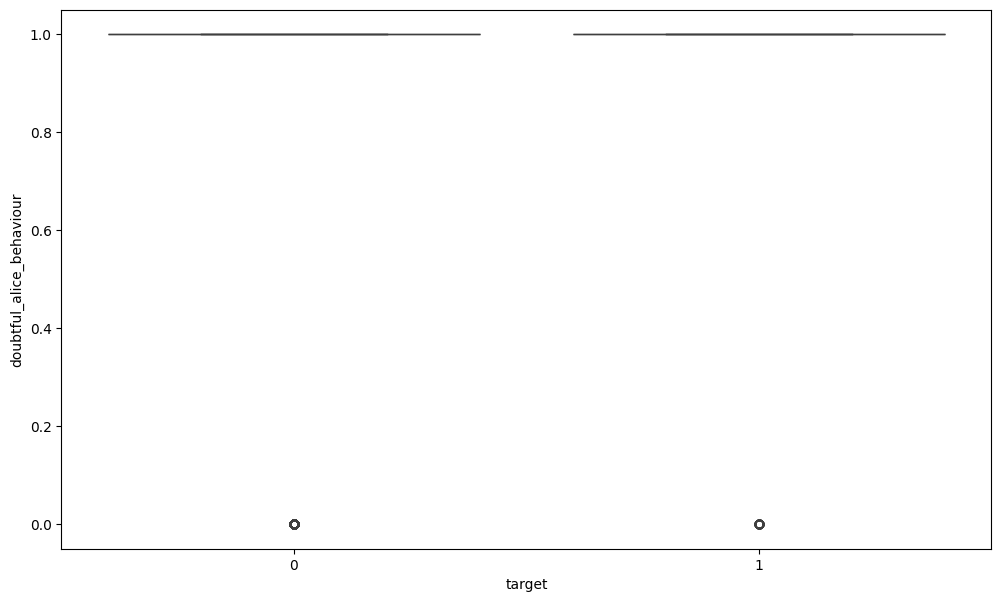

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
df_user.plot_boxplot('doubtful_alice_behaviour', ax)

## 2.5 Remove features
To prepare the dataset for model training, we eliminate features that are either not informative or unsuitable for direct use in machine learning algorithms. Specifically, the following categories of features are removed:

- Raw site and time data: The columns site[1–10], time[1–10], site[1–10]_name, site[1–10]_tld, and site[1–10]_domain_name are excluded because they are either high-dimensional, redundant, or have already been used to derive more meaningful features.

- User activity: The intermediate feature user_activity, used to generate the doubtful_alice_behaviour variable, is no longer necessary and is thus removed.

- Low-variance features: Columns such as is_midnight_activity and is_year_start are dropped due to lack of variance—they contain only a single value across all observations and therefore provide no discriminative power to the model.

This feature pruning ensures that the dataset is streamlined for training, enhancing model efficiency and reducing the risk of overfitting.

In [70]:
# remove features
def remove_features(dataset):
    df = dataset.copy()
    
    # drop site columns
    df.drop(columns=[f'site{i+1}' for i in range(10)], inplace=True)
    df.drop(columns=[f'site{i+1}_name' for i in range(10)], inplace=True, errors='ignore')
    df.drop(columns=[f'site{i+1}_tld' for i in range(10)], inplace=True, errors='ignore')
    df.drop(columns=[f'site{i+1}_domain_name' for i in range(10)], inplace=True, errors='ignore')

    # drop time columns
    df.drop(columns=[f'time{i+1}' for i in range(10)], inplace=True)
    df.drop(columns=['session_start_time'], inplace=True)
    df.drop(columns=['session_end_time'], inplace=True)
    df.drop(columns=['is_midnight_activity'], inplace=True)
    df.drop(columns=['is_year_start'], inplace=True)

    # drop user_activity
    df.drop(columns=['user_activity'], inplace=True, errors='ignore')
    return df


In [71]:
# create features and remove unnecessary features
def operate_features(dataset, site_dic, activity):
    df = dataset.copy()
    df = time_operations(df)
    df = site_operations(df, site_dic)
    df = user_operation(df, activity)
    df = remove_features(df)
    return df

In [72]:
# train data
df_train_operated = operate_features(df_train, site_dic, activity)
X_train = df_train_operated.drop(columns=['target', 'session_id'], axis=1)
y_train = df_train_operated.target

# test data
df_test_operated = operate_features(df_test, site_dic, activity)
X_test = df_test_operated.drop(columns=['session_id'], axis=1)
session_ids =  df_test_operated.session_id

## 2.6 Plot Correlation matrix
In this step, we visualize the correlation matrix of the engineered features, excluding categorical features such as mode_tld and mode_domain. By inspecting the matrix, we observe that several features exhibit strong pairwise correlations (with Pearson correlation coefficients r≥0.7).

Despite the presence of multicollinearity, we opt not to remove these correlated features at this stage. The rationale for this decision is to preserve potentially valuable information that may influence model performance. Instead, we will monitor feature importance and multicollinearity effects during model evaluation and adjust accordingly if necessary.

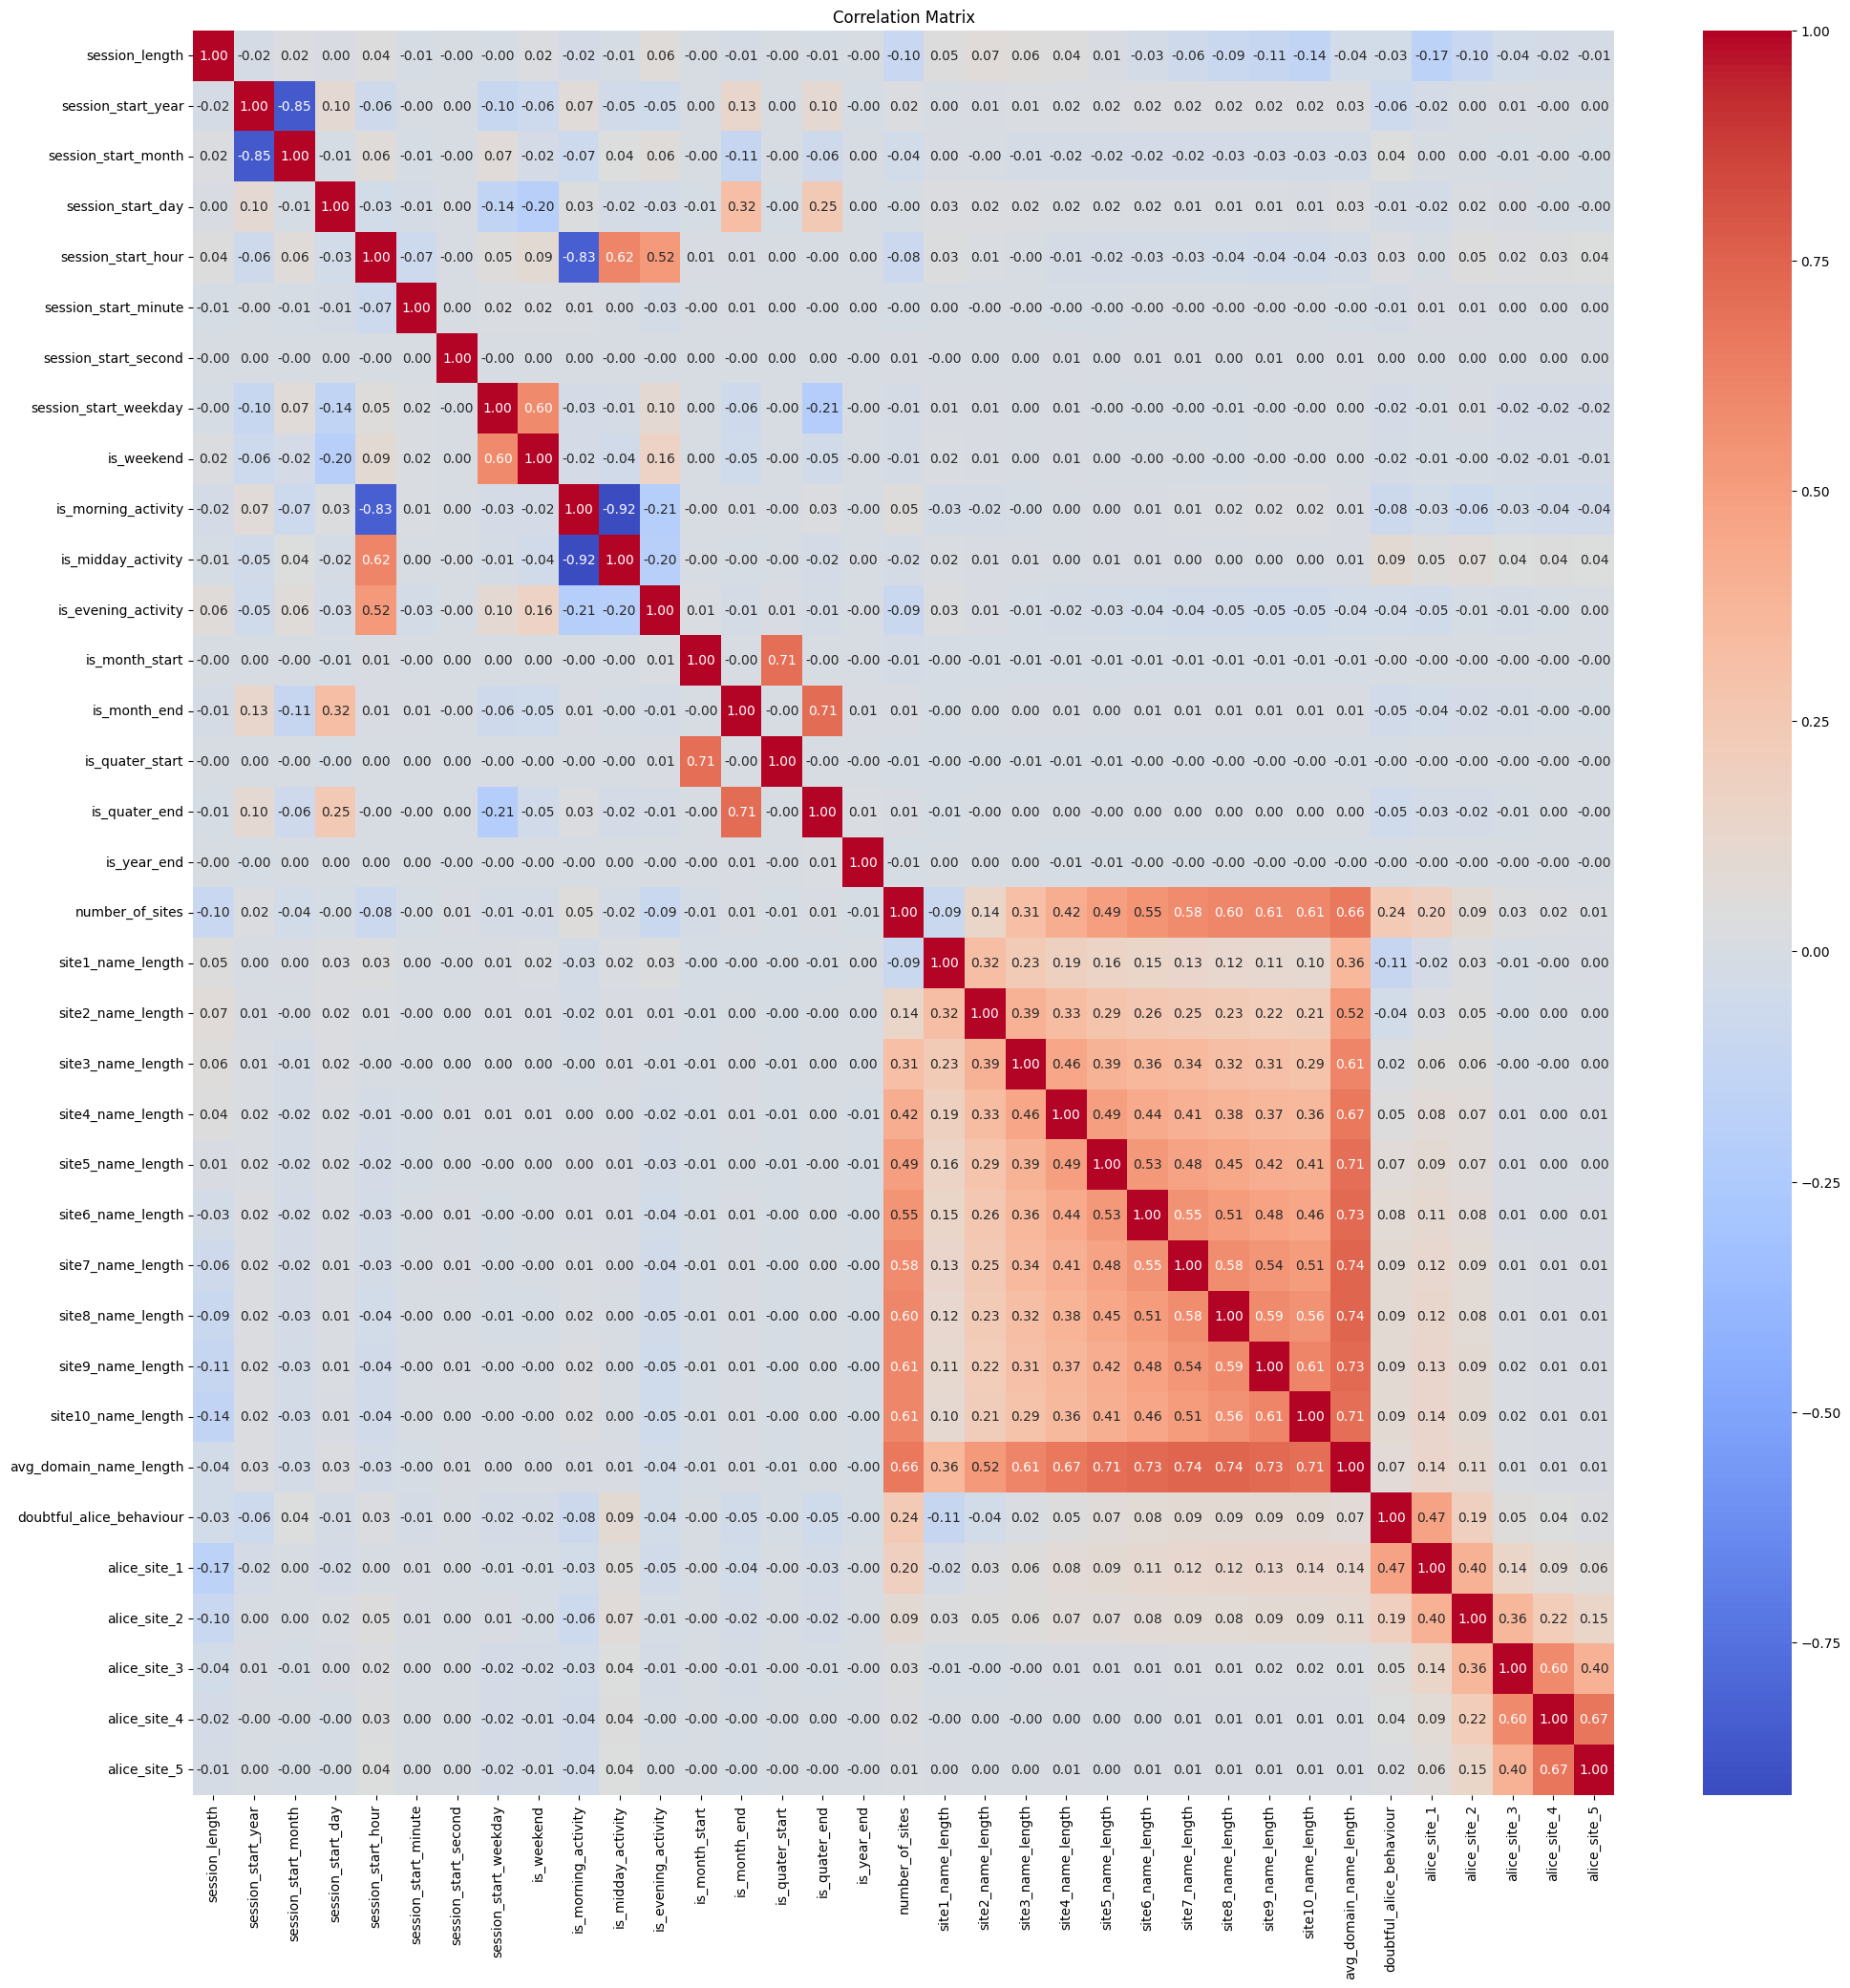

In [73]:
correlation_matrix = X_train.drop(['mode_tld', 'mode_domain'], axis=1).corr()

plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [74]:
# Number of dimensionality
print(f'Dimensionality: {len(X_train.columns)}')

Dimensionality: 37


## 2.7 Plot UMAP
To further explore the structure of the data and assess the separability of the target class, we apply Uniform Manifold Approximation and Projection (UMAP) for dimensionality reduction and visualization.

Upon plotting, we observe that the data points corresponding to Alice exhibit a degree of clustering and appear to be non-uniformly distributed across the projection space. This suggests that Alice's sessions may form distinct behavioral patterns, differentiable from those of other users.

These results indicate the potential feasibility of learning algorithms to distinguish Alice's sessions based on the engineered features.

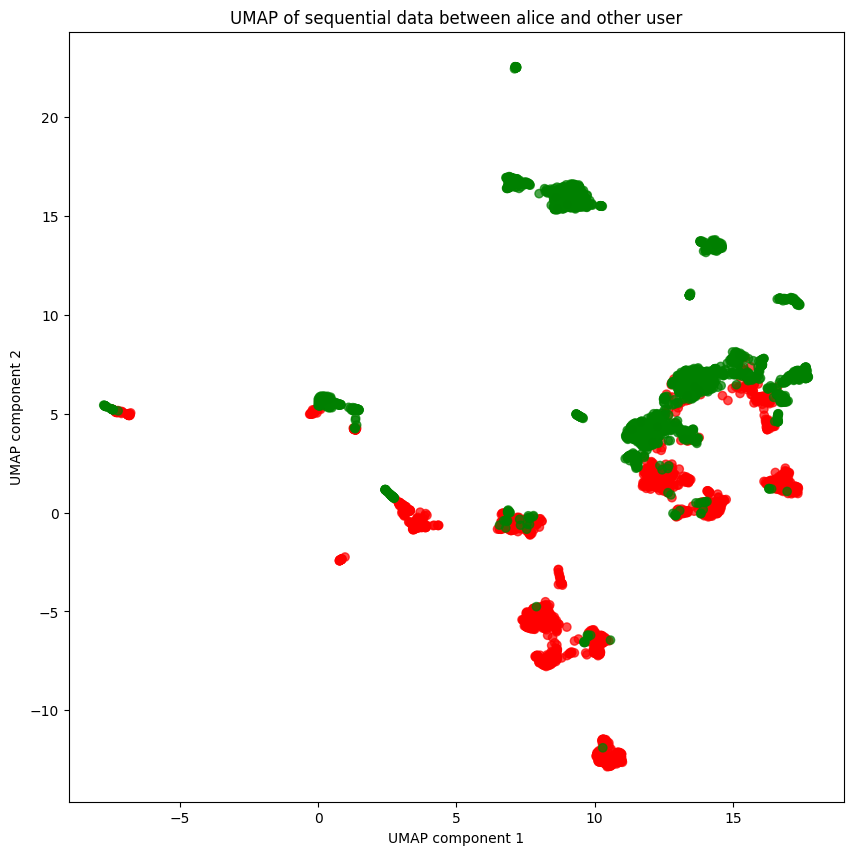

In [75]:
def plot_umap(dataset, y_label='target'):
    ros = RandomUnderSampler(sampling_strategy='auto')
    X_resampled, y_resampled = ros.fit_resample(dataset, dataset.target)
    y_train = y_resampled
    X_scaled = StandardScaler().fit_transform(X_resampled.drop(['mode_tld', 'mode_domain'], axis=1))

    # set the colors to category
    palette = {0: "red", 1: "green"}
    colors = [palette[label] for label in y_train]
    
    # apply UMAP
    umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean',  n_jobs=1, random_state=42)
    X_embedded = umap_model.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, alpha=0.7)
    
    plt.xlabel("UMAP component 1")
    plt.ylabel("UMAP component 2")
    plt.title("UMAP of sequential data between alice and other user")

plot_umap(df_train_operated)

# 3. Model Architectures
To classify user sessions as belonging to the target user (Alice) or not, we design three neural network architectures. As part of preprocessing, categorical features such as Top-Level Domains (TLD) and Domain Names are embedded into continuous vector spaces. These embeddings are concatenated with the remaining numerical features to form the model input.

The following architectures are considered:

Model 1: Fully Connected Neural Network (Dense-only)
This baseline model leverages only dense (fully connected) layers to learn discriminative patterns from the input features.
```
Input → Dense(64, activation='relu') → Dense(32, activation='relu') → Dense(1, activation='sigmoid')
```

Model 2: Convolutional Neural Network (CNN)
This model introduces a 1D Convolutional Layer prior to the dense layers to capture local feature patterns and interactions.
```
Input → Conv1D(64, kernel_size=3, activation='relu') → Dense(64, activation='relu') → Dense(32, activation='relu') → Dense(1, activation='sigmoid')
```

Model 3: Long Short-Term Memory Network (LSTM)
To incorporate potential sequential dependencies in user activity, this model adds an LSTM layer before the dense layers. It is particularly suited to model temporal patterns or ordered sequences in the data.
```
Input → LSTM(64) → Dense(64, activation='relu') → Dense(32, activation='relu') → Dense(1, activation='sigmoid')
```

Each model is trained to minimize binary cross-entropy loss, and performance is evaluated using appropriate metrics such as AUC-ROC, precision, recall, and F1-score.



In [76]:
ac_record = UserActivityRecord(df_train)

## 3.1 Dense Layer-Only
In this approach, we construct a baseline binary classification model using only fully connected (dense) layers. This model assumes that meaningful patterns can be learned from the aggregated feature space without explicitly modeling local dependencies or sequential structure.

In [77]:
class BaselineModel(tf.keras.Model):
    def __init__(self, dataset, num_classes=1):
        super(BaselineModel, self).__init__()

        num_tld = dataset['mode_tld'].nunique() + 1
        self.tld_embedding = Embedding(input_dim=num_tld, output_dim=3, name='tld_embedding')
        num_domain = dataset['mode_domain'].nunique() + 1
        self.domain_embedding = Embedding(input_dim=num_domain, output_dim=3, name='domain_embedding')
        
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        input1, input2, input3 = inputs

        # Input layer
        x1 = self.tld_embedding(input1)
        x1 = Flatten()(x1)
        x2 = self.domain_embedding(input2)
        x2 = Flatten()(x2)
        x3 = input3
        input_merged = Concatenate()([x1, x2, x3])

        # Dense layer
        x = self.dense1(input_merged)
        x = self.dense2(x)

        # Output layer
        output = self.output_layer(x)
        return output

    def build(self, input_shape):
        super(BaselineModel, self).build(input_shape)

def create_baseline_model(dataframe):
    # create input
    input1 = Input(shape=(1,), name='mode_tld')
    input2 = Input(shape=(1,), name='mode_domain')
    input_size = dataframe.shape[1] - 2
    input3 = Input(shape=(input_size,), name='other_data')

    # create output
    model = BaselineModel(dataframe, num_classes=1)
    output = model([input1, input2, input3])

    # create model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    # compile model
    model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', AUC(name='auc')])
    return model

baseline_model = create_baseline_model(X_train)
baseline_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mode_tld (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mode_domain (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_data (InputLayer)   │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ baseline_model            │ (None, 1)              │         23,230 │ mode_tld[0][0],        │
│ (BaselineModel)           │                        │                │ mode_domain[0][0],     │
│                           │                        │                │ other_data[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,230 (90.74 KB)

 Trainable params: 23,230 (90.74 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
class ModelExecutor:
    def __init__(self, model, X_train, y_train, X_test, session_ids):
        ## train data
        # label encoding tld, domain
        self.label_encoder_tld = LabelEncoder()
        self.label_encoder_domain = LabelEncoder()
        mode_tld_input_data = self.label_encoder_tld.fit_transform(X_train['mode_tld'])
        mode_domain_input_data = self.label_encoder_domain.fit_transform(X_train['mode_domain'])

        # other input
        other_input_data = X_train.drop(columns=['mode_tld', 'mode_domain'])

        # combine inputs
        self.X_train = [mode_tld_input_data, mode_domain_input_data, other_input_data]
        self.y_train = y_train

        ## test data
        # label encoding tld, domain
        mode_tld_test_input_data = self.label_encoder_tld.fit_transform(X_test['mode_tld'])
        mode_domain_test_input_data = self.label_encoder_domain.fit_transform(X_test['mode_domain'])
        # other input
        test_other_input_data = X_test.drop(columns=['mode_tld', 'mode_domain'])
        # combine inputs
        self.X_test = [mode_tld_test_input_data, mode_domain_test_input_data, test_other_input_data]
        self.session_ids = session_ids

        self.model = model

    def fit(self, epochs=10, batch_size=32):
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    def predict(self):
        self.y_pred_prob = self.model.predict(self.X_train)

    def plot_metrics(self):
        plt.figure(figsize=(20, 10), dpi=120)
        plt.subplot(1, 3, 1)
        # loss
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # accuracy
        plt.subplot(1, 3, 2)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # AUC
        plt.subplot(1, 3, 3)
        plt.plot(self.history.history['auc'], label='Training AUC')
        plt.plot(self.history.history['val_auc'], label='Validation AUC')
        plt.title('AUC over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
        
        plt.tight_layout()

    def plot_roc_curve(self):
        fpr, tpr, thresholds = roc_curve(self.y_train, self.y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # plot
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')

    def create_submission_file(self, session_ids, name):
        y_pred_prob = self.model.predict(self.X_test)
        output = pd.DataFrame({'session_id': self.session_ids,
                               'target': y_pred_prob.squeeze()
                              })
        output.to_csv(f"{name}_submission.csv", index=False)

baseline_model_executor = ModelExecutor(baseline_model, X_train, y_train, X_test, session_ids)
baseline_model_executor.fit()

Epoch 1/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9823 - auc: 0.5795 - loss: 1.1619 - val_accuracy: 0.9919 - val_auc: 0.8288 - val_loss: 0.0429
Epoch 2/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9895 - auc: 0.7316 - loss: 0.0844 - val_accuracy: 0.9864 - val_auc: 0.9560 - val_loss: 0.0479
Epoch 3/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9915 - auc: 0.8313 - loss: 0.0413 - val_accuracy: 0.9734 - val_auc: 0.9582 - val_loss: 0.0848
Epoch 4/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9920 - auc: 0.9051 - loss: 0.0313 - val_accuracy: 0.9901 - val_auc: 0.9599 - val_loss: 0.0422
Epoch 5/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9923 - auc: 0.9256 - loss: 0.0287 - val_accuracy: 0.9900 - val_auc: 0.9635 - val_loss: 0.0382
Epoch 6/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9926 - auc: 0.9382 - loss: 0.0273 - val_accuracy: 0.9907 - val_auc: 0.9639 - val_loss: 0.0361
Epoch 7/10
6339/6339 ━

In [79]:
baseline_model_executor.predict()

7924/7924 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


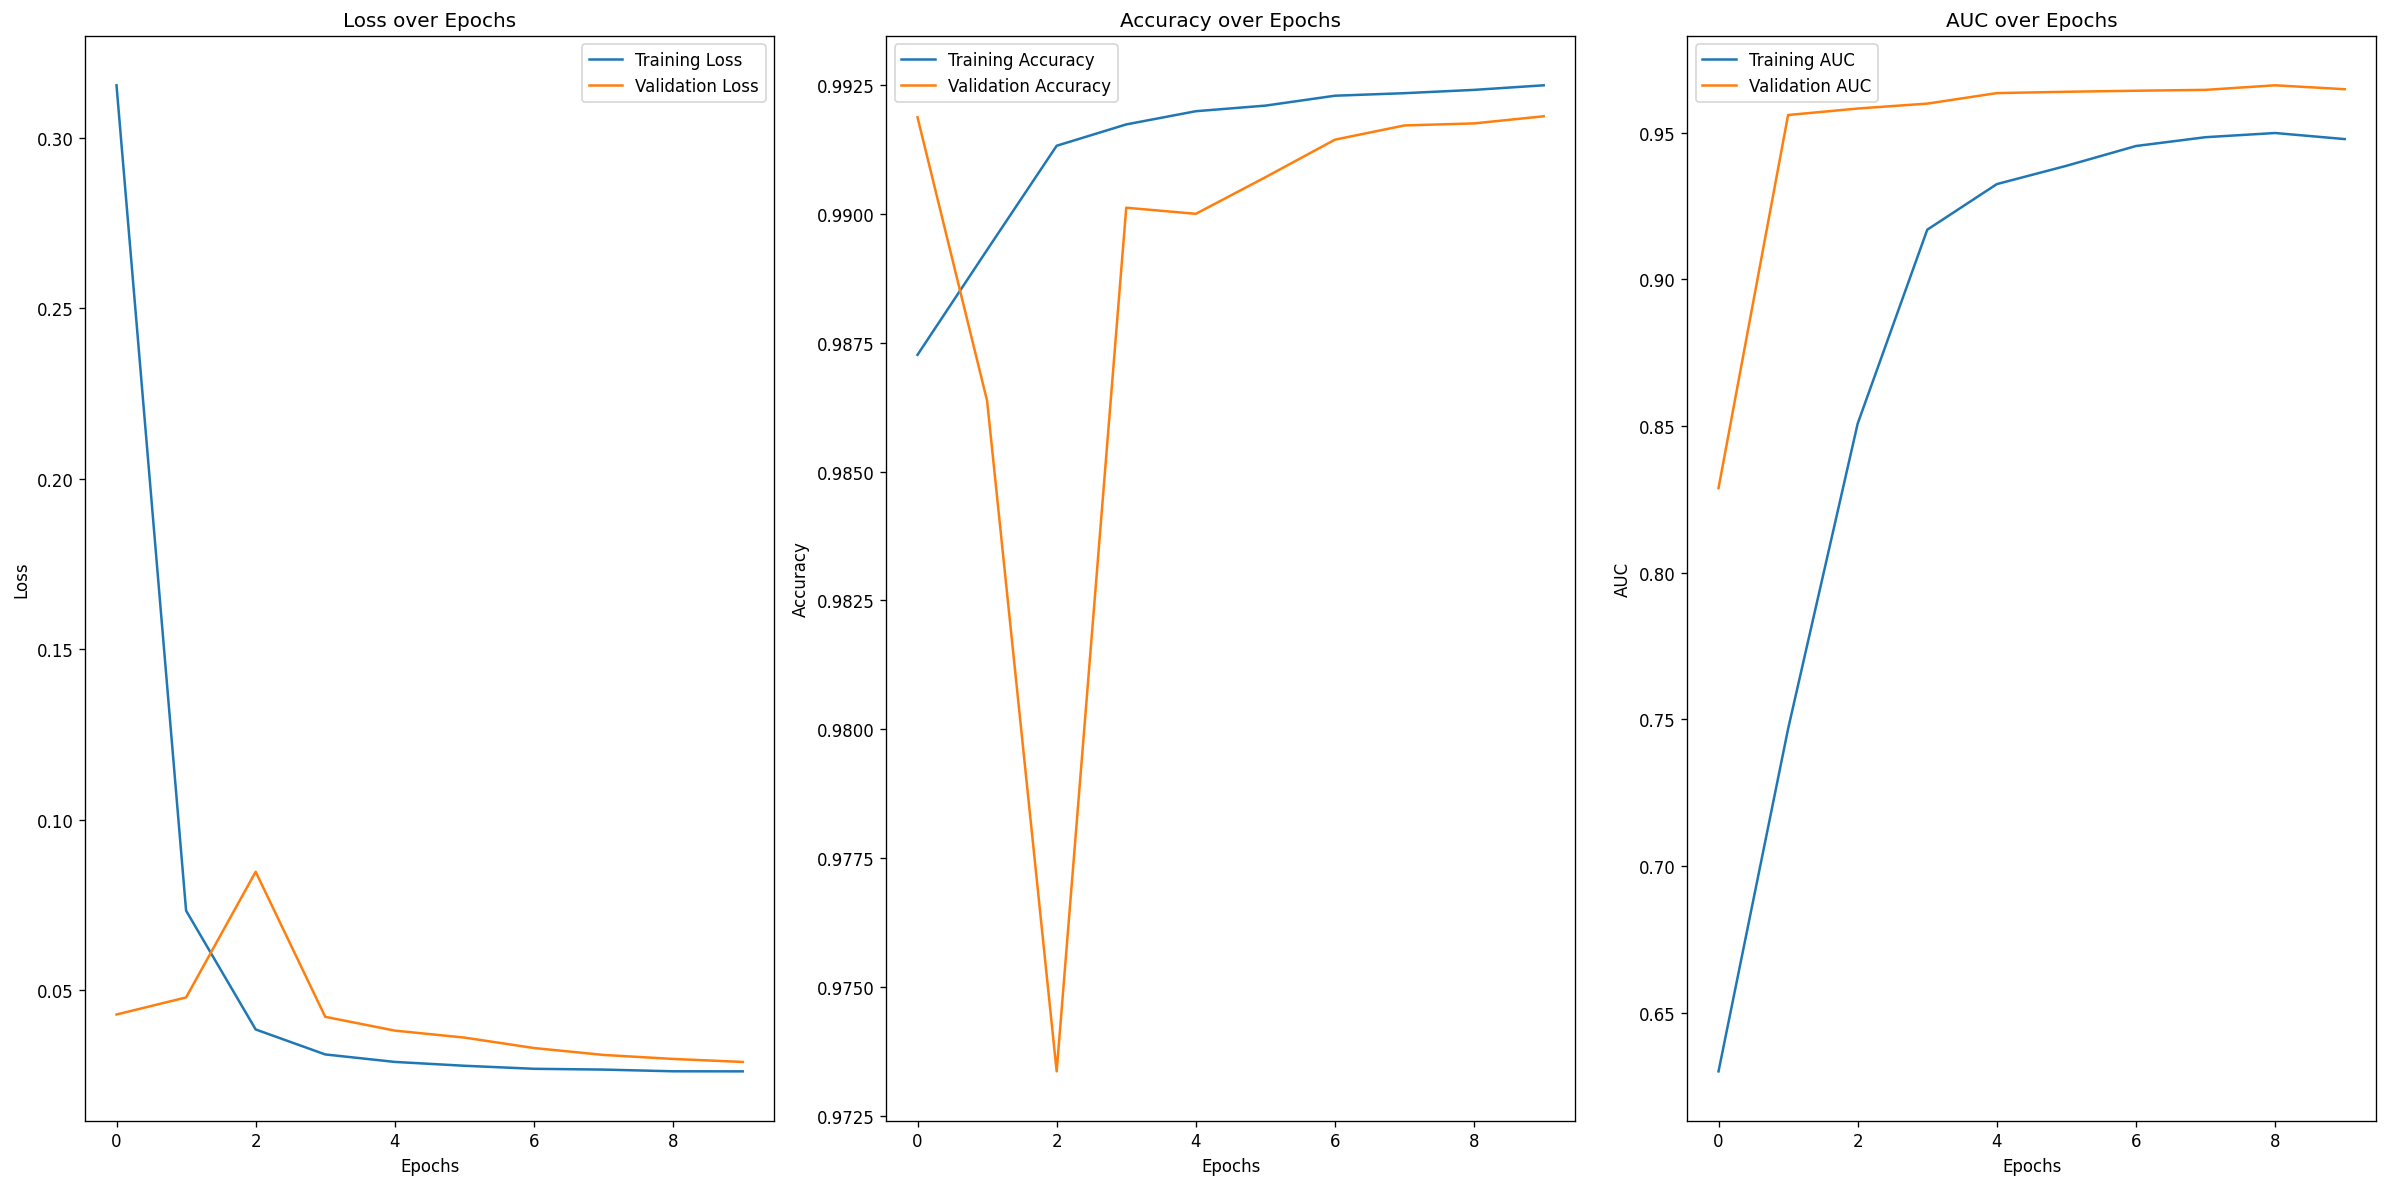

In [80]:
baseline_model_executor.plot_metrics()

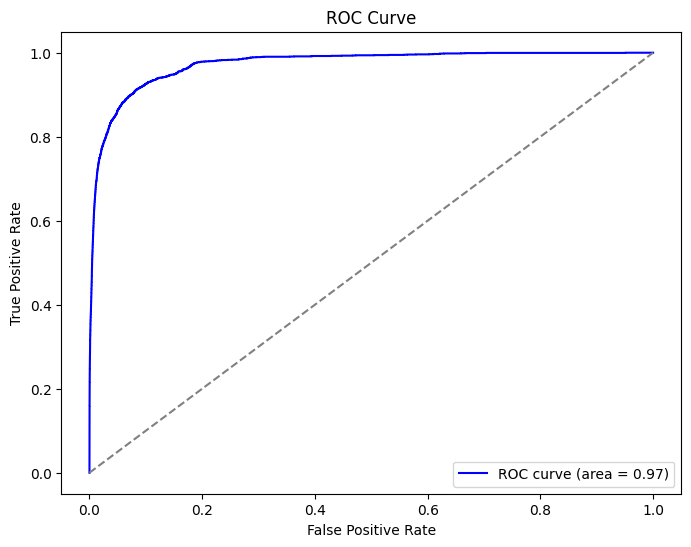

In [81]:
baseline_model_executor.plot_roc_curve()

In [82]:
baseline_model_executor.create_submission_file(session_ids, 'baseline_model')

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


## 3.2 CNNModel
Convolutional Neural Networks (CNNs) are commonly used in image recognition and processing tasks due to their ability to capture local spatial hierarchies within data. Although CNNs are traditionally applied to grid-like data (e.g., images), they have been successfully adapted to sequential and tabular data as well, especially for tasks where local feature extraction plays a crucial role.

In [83]:
class CNNModel(tf.keras.Model):
    def __init__(self, dataset, num_classes=1):
        super(CNNModel, self).__init__()

        num_tld = dataset['mode_tld'].nunique() + 1
        self.tld_embedding = Embedding(input_dim=num_tld, output_dim=3, name='tld_embedding')
        num_domain = dataset['mode_domain'].nunique() + 1
        self.domain_embedding = Embedding(input_dim=num_domain, output_dim=3, name='domain_embedding')

        self.cnn = Conv1D(64, 1, activation='relu')
        
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(num_classes, activation='sigmoid')

        self.dropout = Dropout(0.3)

    def call(self, inputs):
        input1, input2, input3 = inputs

        # Input layer
        x1 = self.tld_embedding(input1)
        x1 = Flatten()(x1)
        x2 = self.domain_embedding(input2)
        x2 = Flatten()(x2)
        x3 = input3
        x = Concatenate()([x1, x2, x3])

        # CNN layer
        # extend dimensions due to applying cnn which needs batch demension.
        x = tf.expand_dims(x, axis=-1)
        x = self.cnn(x)
        x = Flatten()(x)

        # Dense layer
        x = self.dense1(x)
        x = self.dense2(x)

        # Output layer
        output = self.output_layer(x)
        return output

    def build(self, input_shape):
        super(CNNModel, self).build(input_shape)

def create_cnn_model(dataframe):
    # create inputs
    input1 = Input(shape=(1,), name='mode_tld')
    input2 = Input(shape=(1,), name='mode_domain')
    input_size = dataframe.shape[1] - 2
    input3 = Input(shape=(input_size,), name='other_data')

    # create output
    model = CNNModel(dataframe, num_classes=1)
    output = model([input1, input2, input3])

    # create model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    # compile model
    model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', AUC(name='auc')])
    return model

cnn_model = create_cnn_model(X_train)
cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mode_tld (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mode_domain (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_data (InputLayer)   │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_model (CNNModel)      │ (None, 1)              │        188,670 │ mode_tld[0][0],        │
│                           │                        │                │ mode_domain[0][0],     │
│                           │                        │                │ other_data[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 188,670 (736.99 KB)

 Trainable params: 188,670 (736.99 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
cnn_model_executor = ModelExecutor(cnn_model, X_train, y_train, X_test, session_ids)
cnn_model_executor.fit()

Epoch 1/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.9896 - auc: 0.7748 - loss: 0.0715 - val_accuracy: 0.9910 - val_auc: 0.9597 - val_loss: 0.0353
Epoch 2/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9926 - auc: 0.9480 - loss: 0.0270 - val_accuracy: 0.9923 - val_auc: 0.9625 - val_loss: 0.0267
Epoch 3/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9932 - auc: 0.9570 - loss: 0.0245 - val_accuracy: 0.9922 - val_auc: 0.9622 - val_loss: 0.0259
Epoch 4/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9932 - auc: 0.9596 - loss: 0.0234 - val_accuracy: 0.9924 - val_auc: 0.9623 - val_loss: 0.0254
Epoch 5/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9933 - auc: 0.9583 - loss: 0.0229 - val_accuracy: 0.9925 - val_auc: 0.9621 - val_loss: 0.0251
Epoch 6/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9933 - auc: 0.9599 - loss: 0.0225 - val_accuracy: 0.9926 - val_auc: 0.9591 - val_loss: 0.0250
Epoch 7/10
6339/6339 ━

In [85]:
cnn_model_executor.predict()

7924/7924 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


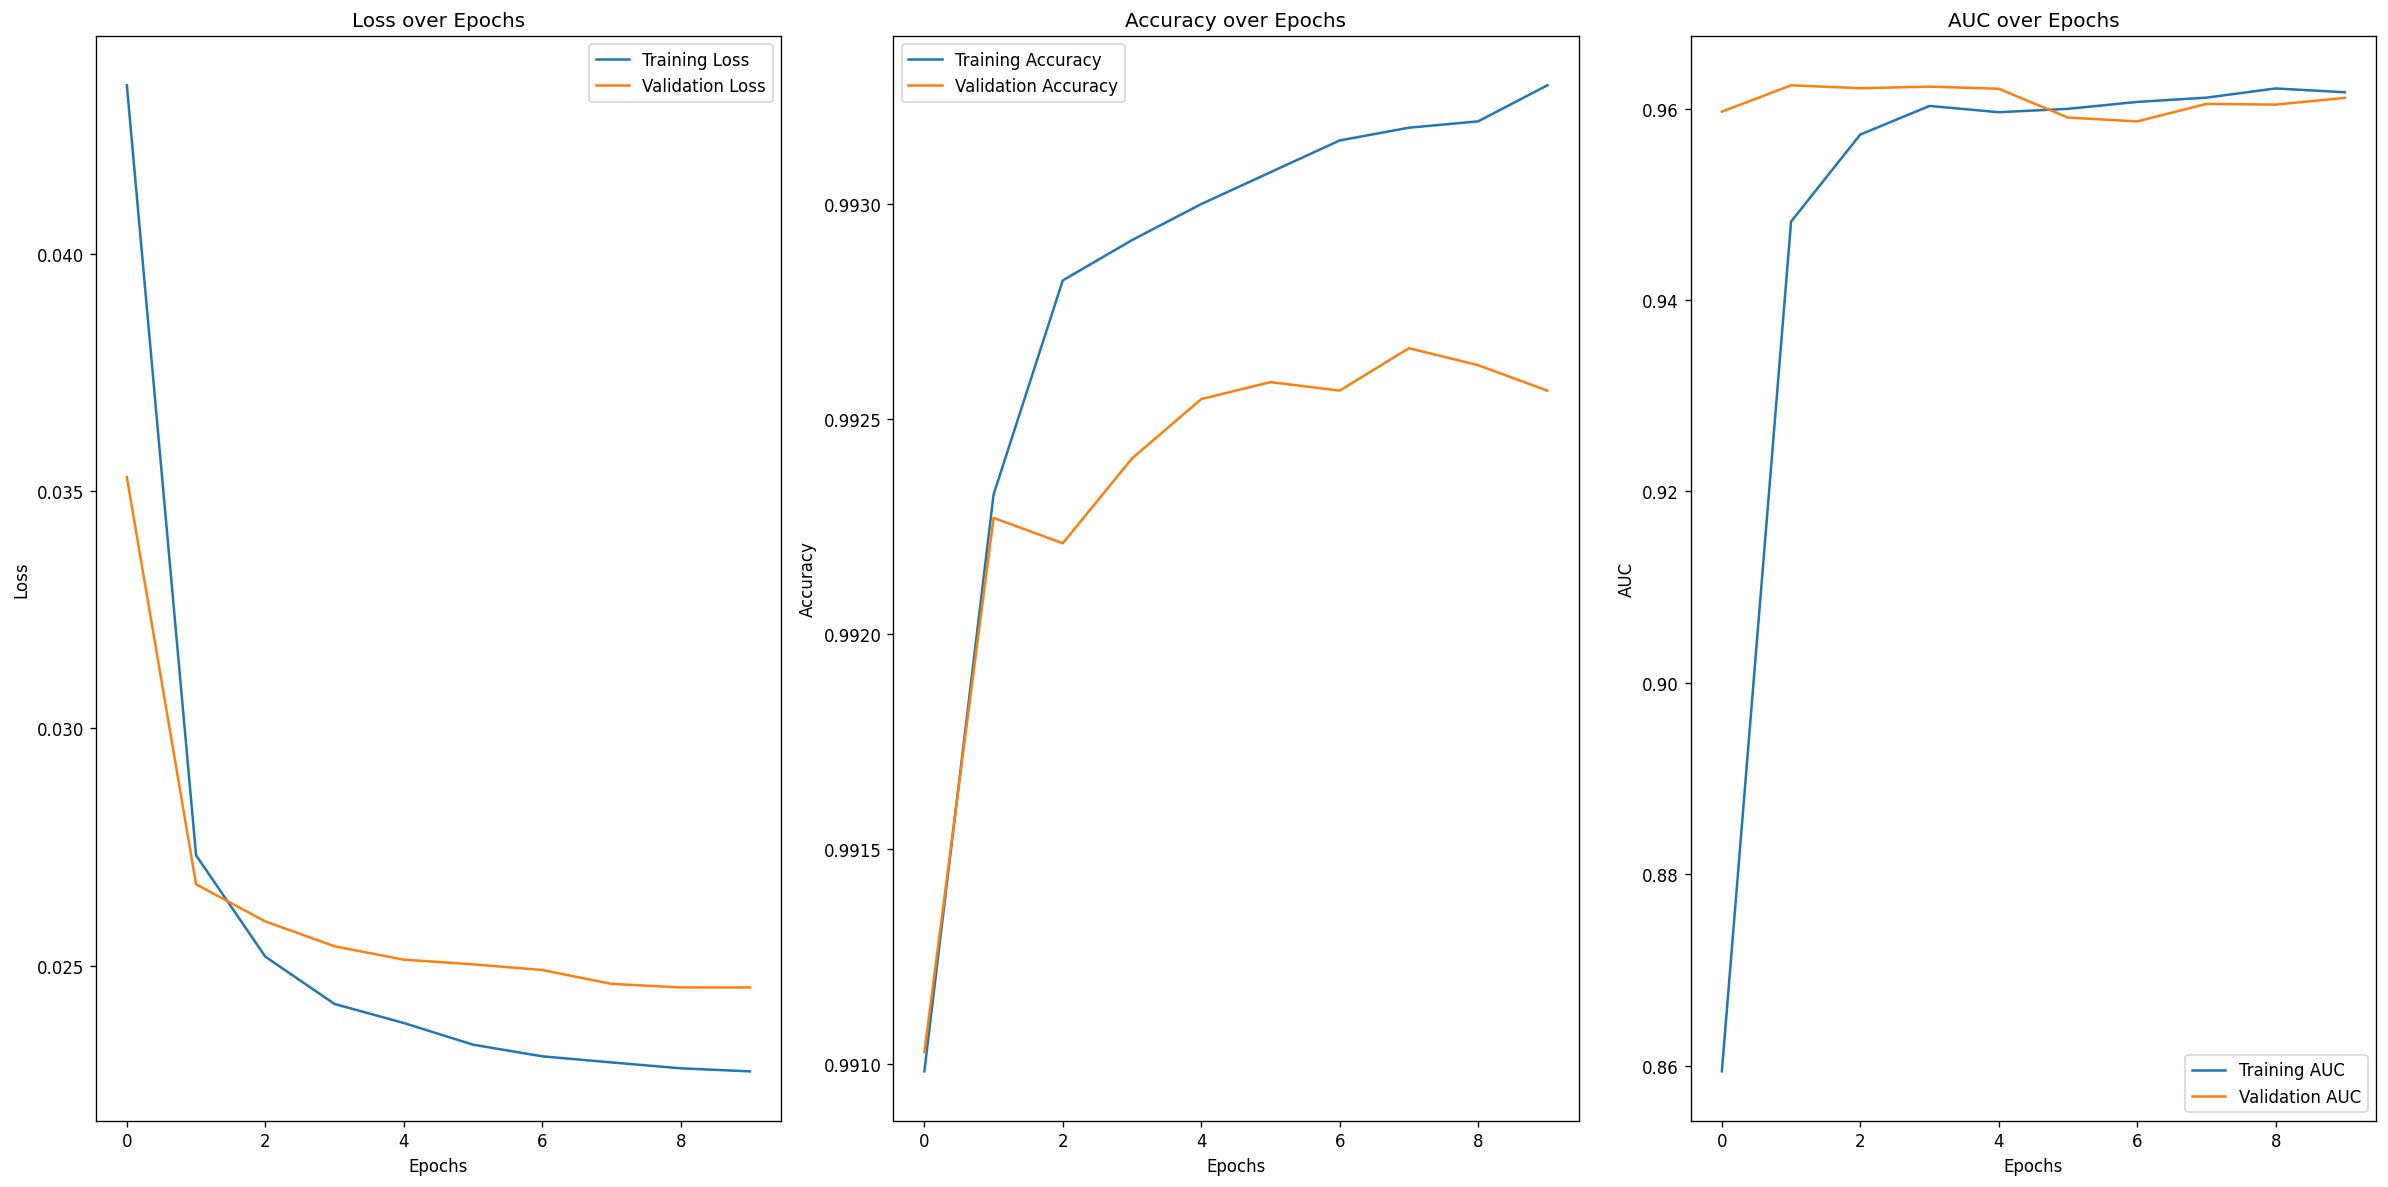

In [86]:
cnn_model_executor.plot_metrics()

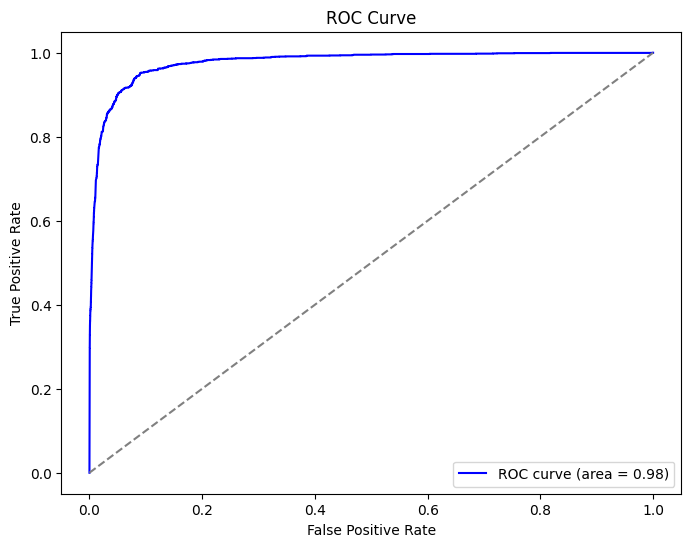

In [87]:
cnn_model_executor.plot_roc_curve()

In [88]:
cnn_model_executor.create_submission_file(session_ids, 'ccn_model')

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


## 3.3 LSTMModel
Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) specifically designed to capture long-range dependencies in sequential data. LSTMs are widely used for tasks such as time-series prediction, natural language processing, and sequence modeling, where the order of the data and the temporal relationships between observations are crucial. Unlike traditional RNNs, LSTMs mitigate the vanishing gradient problem and can effectively learn long-term dependencies by using memory cells and gating mechanisms.

In [89]:
class LSTMModel(tf.keras.Model):
    def __init__(self, dataset, num_classes=1):
        super(LSTMModel, self).__init__()

        num_tld = dataset['mode_tld'].nunique() + 1
        self.tld_embedding = Embedding(input_dim=num_tld, output_dim=3, name='tld_embedding')
        num_domain = dataset['mode_domain'].nunique() + 1
        self.domain_embedding = Embedding(input_dim=num_domain, output_dim=3, name='domain_embedding')

        self.lstm = LSTM(64)
        
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        input1, input2, input3 = inputs
        # Input layer
        x1 = self.tld_embedding(input1)
        x1 = Flatten()(x1)
        x2 = self.domain_embedding(input2)
        x2 = Flatten()(x2)
        x3 = input3
        x = Concatenate()([x1, x2, x3])

        # LSTM layer
        x = tf.expand_dims(x, axis=-1)
        x = self.lstm(x)

        # Dense layer
        x = self.dense1(x)
        x = self.dense2(x)

        # output layer
        output = self.output_layer(x)
        return output

    def build(self, input_shape):
        super(LSTMModel, self).build(input_shape)

def create_lstm_model(dataframe):
    # create input
    input1 = Input(shape=(1,), name='mode_tld')
    input2 = Input(shape=(1,), name='mode_domain')
    input_size = dataframe.shape[1] - 2
    input3 = Input(shape=(input_size,), name='other_data')

    # create output
    model = LSTMModel(dataframe, num_classes=1)
    output = model([input1, input2, input3])

    # create model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    # compile model
    model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', AUC(name='auc')])
    return model

lstm_model = create_lstm_model(X_train)
lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mode_tld (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mode_domain (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_data (InputLayer)   │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_model (LSTMModel)    │ (None, 1)              │         41,598 │ mode_tld[0][0],        │
│                           │                        │                │ mode_domain[0][0],     │
│                           │                        │                │ other_data[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 41,598 (162.49 KB)

 Trainable params: 41,598 (162.49 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
lstm_model_executor = ModelExecutor(lstm_model, X_train, y_train, X_test, session_ids)
lstm_model_executor.fit()

Epoch 1/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 128s 20ms/step - accuracy: 0.9906 - auc: 0.8427 - loss: 0.0434 - val_accuracy: 0.9920 - val_auc: 0.9482 - val_loss: 0.0290
Epoch 2/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 126s 20ms/step - accuracy: 0.9929 - auc: 0.9428 - loss: 0.0263 - val_accuracy: 0.9919 - val_auc: 0.9526 - val_loss: 0.0266
Epoch 3/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 126s 20ms/step - accuracy: 0.9932 - auc: 0.9500 - loss: 0.0242 - val_accuracy: 0.9919 - val_auc: 0.9496 - val_loss: 0.0261
Epoch 4/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 127s 20ms/step - accuracy: 0.9932 - auc: 0.9562 - loss: 0.0230 - val_accuracy: 0.9924 - val_auc: 0.9600 - val_loss: 0.0237
Epoch 5/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 127s 20ms/step - accuracy: 0.9933 - auc: 0.9596 - loss: 0.0215 - val_accuracy: 0.9932 - val_auc: 0.9690 - val_loss: 0.0221
Epoch 6/10
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 127s 20ms/step - accuracy: 0.9937 - auc: 0.9621 - loss: 0.0198 - val_accuracy: 0.9938 - val_auc: 0.9675 - val_loss: 0.0207
Epoch 7/10

In [91]:
lstm_model_executor.predict()

7924/7924 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step


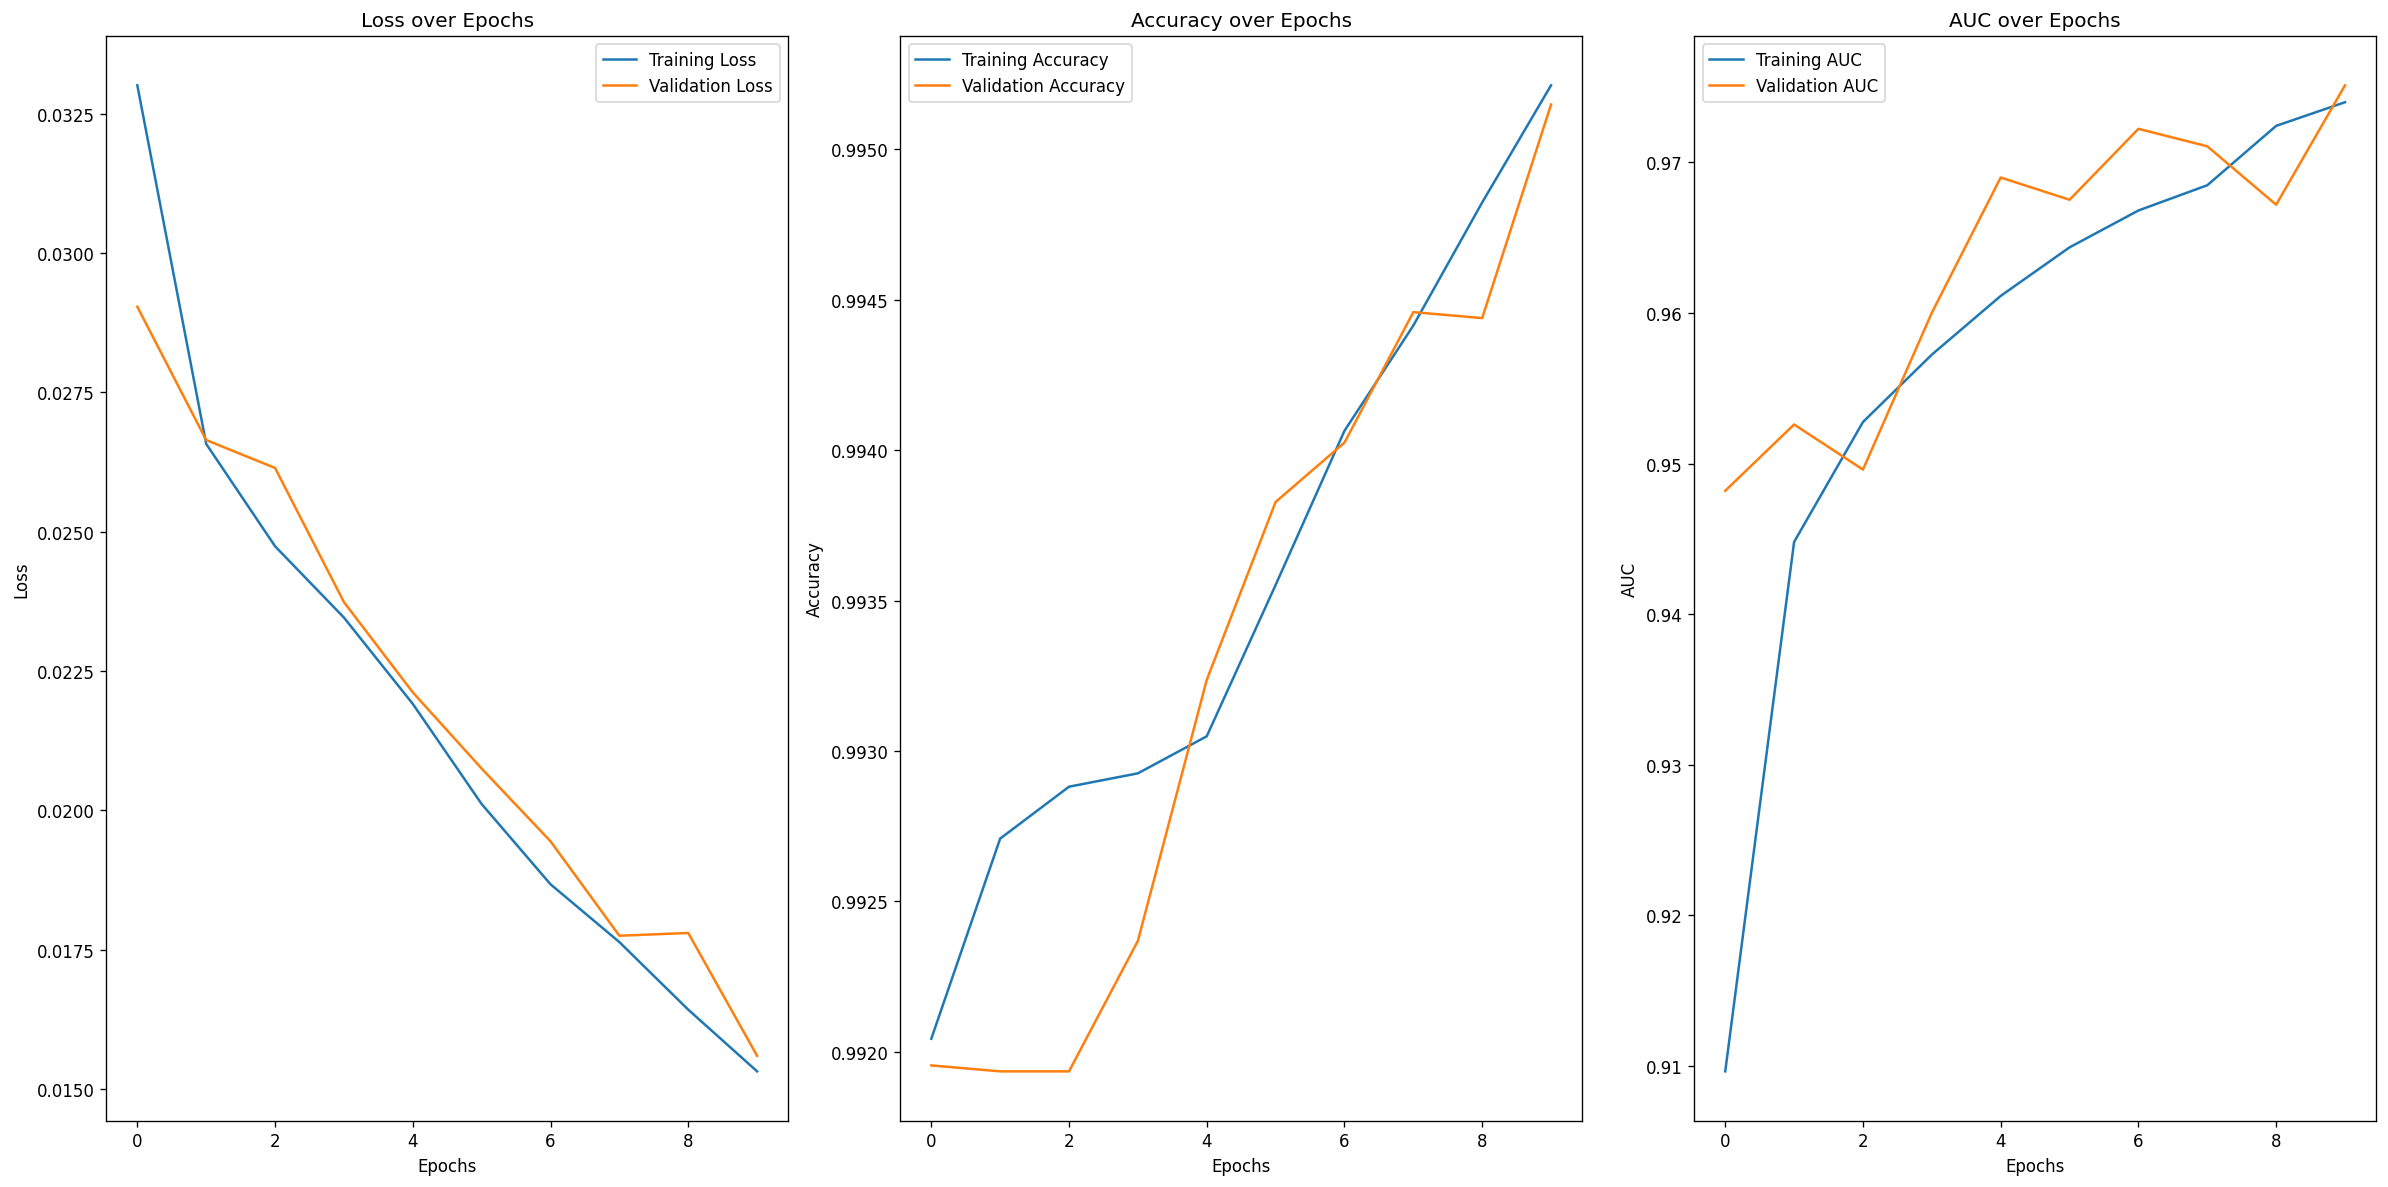

In [92]:
lstm_model_executor.plot_metrics()

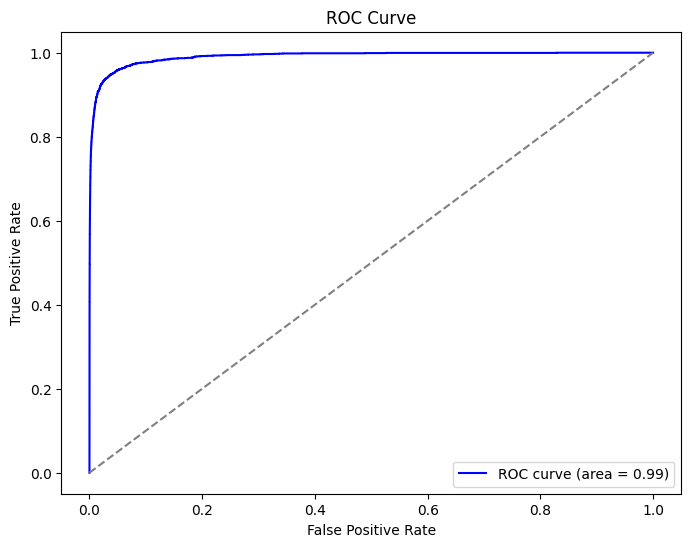

In [93]:
lstm_model_executor.plot_roc_curve()

In [94]:
lstm_model_executor.create_submission_file(session_ids, 'lstm_model')

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step


# 4. Model tuning

## 4.1 Regularization
In order to preserve the distribution of the data while applying regularization, we utilize MinMaxScaler rather than StandardScaler to scale the input values. However, given that mode_tld and mode_domain are categorical variables, they are excluded from the scaling process.

In [95]:
def min_max_regularization(dataframe):
    df = dataframe.copy()
    drop_to_columns = ['mode_tld', 'mode_domain']
    df_dropped = df.drop(drop_to_columns, axis=1)
    scaler = MinMaxScaler()
    
    scaled_data = scaler.fit_transform(df_dropped)
    df_scaled = pd.DataFrame(scaled_data, columns=df_dropped.columns)
    df_restored = pd.concat([df_scaled, df[drop_to_columns]], axis=1)
    
    return df_restored

In [96]:
X_train = min_max_regularization(X_train)
X_test = min_max_regularization(X_test)

## 4.2 Model Tuning
In each model, we apply a Dropout layer, and for the LSTM model, we set the recurrent_dropout parameter. The dropout rate for all layers is set to 0.3. This regularization technique helps to prevent overfitting by randomly setting a fraction of the input units to 0 during training.

## 4.3 Hyper-parameter Tuning
In this experiment, we utilize the Adamax optimizer, which is commonly used in NLP tasks. We expect that by increasing the dropout rate, the risk of overfitting will be reduced, and thus, we increase the number of epochs from 10 to 20 and set the batch size to 16. Normally, Early Stopping would be used to terminate the training early, but in this case, we leave it for comparison purposes.

## 4.4 Model Execute
The models will be tuned as described below:
- Tuned Model1: Dense-layer only
Input -> Dense(64, relu) -> BatchNormalization -> Dropout(0.3) -> Dense(32, relu) -> BatchNormalization -> Dropout(0.3) -> Dense(1, sigmoid)
- Model2: CNN
Input -> CNN(64) -> BatchNormalization -> Dense(64, relu) -> BatchNormalization -> Dropout(0.3) -> Dense(32, relu) -> BatchNormalization -> Dropout(0.3) -> Dense(1, sigmoid)
- Model3: LSTM (Recurrent Neural Network)
Input -> LSTM(64, recurrent_dropout=0.3) -> BatchNormalization -> Dropout(0.3) -> Dense(32, relu) -> BatchNormalization -> Dropout(0.3) -> Dense(1, sigmoid)


### 4.4.1 Tuned Dense Layer Only Model

In [97]:
class TunedBaselineModel(tf.keras.Model):
    def __init__(self, dataset, num_classes=1):
        super(TunedBaselineModel, self).__init__()

        # embedding model tld
        num_tld = dataset['mode_tld'].nunique() + 1
        self.tld_embedding = Embedding(input_dim=num_tld, output_dim=3, name='tld_embedding')
        # embedding mode domain
        num_domain = dataset['mode_domain'].nunique() + 1
        self.domain_embedding = Embedding(input_dim=num_domain, output_dim=3, name='domain_embedding')

        # setup layers
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(num_classes, activation='sigmoid')

        # additional layers
        self.dropout = Dropout(0.3)
        self.batchnormalization1 = BatchNormalization()
        self.batchnormalization2 = BatchNormalization()

    def call(self, inputs):
        input1, input2, input3 = inputs

        # Input layer
        x1 = self.tld_embedding(input1)
        x1 = Flatten()(x1)
        x2 = self.domain_embedding(input2)
        x2 = Flatten()(x2)
        x3 = input3
        input_merged = Concatenate()([x1, x2, x3])

        # Dense layer
        x = self.dense1(input_merged)
        x = self.batchnormalization1(x) # add batch normalization layer
        x = self.dropout(x) # add dropout layer
        x = self.dense2(x)
        x = self.batchnormalization2(x) # add batch normalization layer
        x = self.dropout(x) # add dropout layer

        # Output layer
        output = self.output_layer(x)
        return output

    def build(self, input_shape):
        super(TunedBaselineModel, self).build(input_shape)

def create_tuned_baseline_model(dataframe):
    # compute input data
    input1 = Input(shape=(1,), name='mode_tld')
    input2 = Input(shape=(1,), name='mode_domain')
    input_size = dataframe.shape[1] - 2
    input3 = Input(shape=(input_size,), name='other_data')

    # compute output data
    model = TunedBaselineModel(dataframe, num_classes=1)
    output = model([input1, input2, input3])

    # create model
    model = Model(inputs=[input1, input2, input3], outputs=output)
    # compile model
    model.compile(optimizer=Adamax(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', AUC(name='auc')])
    return model

tuned_baseline_model = create_tuned_baseline_model(X_train)
tuned_baseline_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mode_tld (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mode_domain (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_data (InputLayer)   │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tuned_baseline_model      │ (None, 1)              │         23,614 │ mode_tld[0][0],        │
│ (TunedBaselineModel)      │                        │                │ mode_domain[0][0],     │
│                           │                        │                │ other_data[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,614 (92.24 KB)

 Trainable params: 23,422 (91.49 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
tuned_baseline_model_executor = ModelExecutor(tuned_baseline_model, X_train, y_train, X_test, session_ids)
tuned_baseline_model_executor.fit(epochs=20, batch_size=16)

Epoch 1/20
12678/12678 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9574 - auc: 0.7639 - loss: 0.1211 - val_accuracy: 0.9915 - val_auc: 0.9537 - val_loss: 0.0278
Epoch 2/20
12678/12678 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9920 - auc: 0.9231 - loss: 0.0299 - val_accuracy: 0.9914 - val_auc: 0.9576 - val_loss: 0.0268
Epoch 3/20
12678/12678 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9924 - auc: 0.9332 - loss: 0.0280 - val_accuracy: 0.9919 - val_auc: 0.9624 - val_loss: 0.0252
Epoch 4/20
 5854/12678 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9927 - auc: 0.9464 - loss: 0.0256

In [ ]:
tuned_baseline_model_executor.predict()

In [ ]:
tuned_baseline_model_executor.plot_metrics()

In [ ]:
tuned_baseline_model_executor.plot_roc_curve()

In [ ]:
tuned_baseline_model_executor.create_submission_file(session_ids, 'tuned_baseline_model')

### 4.4.2 Tuned CNNModel

In [ ]:
class TunedCNNModel(tf.keras.Model):
    def __init__(self, dataset, num_classes=1):
        super(TunedCNNModel, self).__init__()

        num_tld = dataset['mode_tld'].nunique() + 1
        self.tld_embedding = Embedding(input_dim=num_tld, output_dim=3, name='tld_embedding')
        num_domain = dataset['mode_domain'].nunique() + 1
        self.domain_embedding = Embedding(input_dim=num_domain, output_dim=3, name='domain_embedding')

        self.cnn = Conv1D(64, 1, activation='relu')
        
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(num_classes, activation='sigmoid')

        # additional layers
        self.dropout = Dropout(0.3)
        self.batchnormalization_cnn = BatchNormalization()
        self.batchnormalization1 = BatchNormalization()
        self.batchnormalization2 = BatchNormalization()

    def call(self, inputs):
        input1, input2, input3 = inputs

        # Input layer
        x1 = self.tld_embedding(input1)
        x1 = Flatten()(x1)
        x2 = self.domain_embedding(input2)
        x2 = Flatten()(x2)
        x3 = input3
        x = Concatenate()([x1, x2, x3])

        # CNN layer
        # extend dimensions due to applying cnn which needs batch demension.
        x = tf.expand_dims(x, axis=-1)
        x = self.cnn(x)
        x = self.batchnormalization_cnn(x)
        
        x = Flatten()(x)

        # Dense layer
        x = self.dense1(x)
        x = self.batchnormalization1(x) # add batch normalization layer
        x = self.dropout(x) # add dropout layer
        x = self.dense2(x)
        x = self.batchnormalization2(x) # add batch normalization layer
        x = self.dropout(x) # add dropout layer

        # Output layer
        output = self.output_layer(x)
        return output

    def build(self, input_shape):
        super(TunedCNNModel, self).build(input_shape)

def create_tuned_cnn_model(dataframe):
    # create input
    input1 = Input(shape=(1,), name='mode_tld')
    input2 = Input(shape=(1,), name='mode_domain')
    input_size = dataframe.shape[1] - 2
    input3 = Input(shape=(input_size,), name='other_data')

    # create output
    model = TunedCNNModel(dataframe, num_classes=1)
    output = model([input1, input2, input3])

    # create model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    # compile model
    model.compile(optimizer=Adamax(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', AUC(name='auc')])
    return model

tuned_cnn_model = create_tuned_cnn_model(X_train)
tuned_cnn_model.summary()

In [ ]:
tuned_cnn_model_executor = ModelExecutor(tuned_cnn_model, X_train, y_train, X_test, session_ids)
tuned_cnn_model_executor.fit(epochs=20, batch_size=16)

In [ ]:
tuned_cnn_model_executor.predict()

In [ ]:
tuned_cnn_model_executor.plot_metrics()

In [ ]:
tuned_cnn_model_executor.plot_roc_curve()

In [ ]:
tuned_cnn_model_executor.create_submission_file(session_ids, 'tuned_cnn_model')

### 4.4.3 Tuned LSTM Model


In [ ]:
class TunedLSTMModel(tf.keras.Model):
    def __init__(self, dataset, num_classes=1):
        super(TunedLSTMModel, self).__init__()

        num_tld = dataset['mode_tld'].nunique() + 1
        self.tld_embedding = Embedding(input_dim=num_tld, output_dim=3, name='tld_embedding')
        num_domain = dataset['mode_domain'].nunique() + 1
        self.domain_embedding = Embedding(input_dim=num_domain, output_dim=3, name='domain_embedding')

        self.lstm = LSTM(64, recurrent_dropout=0.3) # add recurrent_dropout
        
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.output_layer = Dense(num_classes, activation='sigmoid')

        # additional layers
        self.dropout = Dropout(0.3)
        self.batchnormalization1 = BatchNormalization()
        self.batchnormalization2 = BatchNormalization()
    
    def call(self, inputs):
        input1, input2, input3 = inputs

        # Input layer
        x1 = self.tld_embedding(input1)
        x1 = Flatten()(x1)
        x2 = self.domain_embedding(input2)
        x2 = Flatten()(x2)
        x3 = input3
        x = Concatenate()([x1, x2, x3])

        # LSTM Layer
        x = tf.expand_dims(x, axis=-1)
        x = self.lstm(x)
        
        # Dense layer
        x = self.dense1(x)
        x = self.batchnormalization1(x) # add batch normalization layer
        x = self.dropout(x) # add dropout layer
        x = self.dense2(x)
        x = self.batchnormalization2(x) # add batch normalization layer
        x = self.dropout(x) # add dropout layer

        output = self.output_layer(x)
        return output

    def build(self, input_shape):
        super(TunedLSTMModel, self).build(input_shape)

def create_tuned_lstm_model(dataframe):
    # create inputs
    input1 = Input(shape=(1,), name='mode_tld')
    input2 = Input(shape=(1,), name='mode_domain')
    input_size = dataframe.shape[1] - 2
    input3 = Input(shape=(input_size,), name='other_data')

    # create output
    model = TunedLSTMModel(dataframe, num_classes=1)
    output = model([input1, input2, input3])

    # create model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    # compile model
    model.compile(optimizer=Adamax(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', AUC(name='auc')])
    return model

tuned_lstm_model = create_tuned_lstm_model(X_train)
tuned_lstm_model.summary()

In [ ]:
tuned_lstm_model_executor = ModelExecutor(tuned_lstm_model, X_train, y_train, X_test, session_ids)
tuned_lstm_model_executor.fit(epochs=20, batch_size=16)

In [ ]:
tuned_lstm_model_executor.predict()

In [ ]:
tuned_lstm_model_executor.plot_metrics()

In [ ]:
tuned_lstm_model_executor.plot_roc_curve()

In [ ]:
tuned_lstm_model_executor.create_submission_file(session_ids, 'tuned_lstm_model')

# 5. Results and Analysis
Since accuracy is not a reliable metric in an imbalanced situation, we will compare the models based on their ROC (Receiver Operating Characteristic) curves to evaluate performance.

When plotting the ROC curves for all models, it is observed that the tuned CNN and tuned baseline models performed the best, exhibiting superior performance compared to other models. On the other hand, the tuned LSTM model demonstrated the poorest performance. This suggests that the LSTM model, despite incorporating the recurrent layer, might not be the most suitable approach for this particular task, especially when dealing with imbalanced data.

In [ ]:
def show_roc_curves(executors, labels):
    # plot diagonal line 
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    for executor, label in zip(executors, labels):
        # plot roc curves
        fpr, tpr, thresholds = roc_curve(executor.y_train, executor.y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')

executors = [baseline_model_executor, cnn_model_executor, lstm_model_executor, 
             tuned_baseline_model_executor, tuned_cnn_model_executor, tuned_lstm_model_executor]
labels = ['baseline', 'cnn', 'lstm', 'tuned_baseline', 'tuned_cnn', 'tuned_lstm']
show_roc_curves(executors, labels)

# 6. Discussion

The feature engineering process was extensive, and the accuracy of each model was reasonably good. However, the LSTM model performed worse compared to the others. In hindsight, this suggests that the current feature structure might not have fully leveraged the potential of LSTM. LSTM is designed to capture sequence information, and I realized that this aspect could have been better utilized.

In this analysis, I used the results from PrefixScan to create features related to potential suspicious behavior by Alice. However, instead of using fixed-length site data, treating the sequence of sites as variable-length embeddings, similar to how NLP models handle sequences, could have led to further improvements in the model's performance. By embedding the site sequences and leveraging the sequential nature, the model may have been able to capture more meaningful patterns, improving overall accuracy.

# 7. Conclusion

Multiple deep learning models were utilized to create features based on a specific user's session data, and the goal was to determine whether the user was Alice or not. The results showed that the CNN model outperformed the others, while the LSTM model had the lowest ROC score.

The next challenge lies in processing the features sequentially to make them more suitable for the LSTM model. By adapting the features to be more aligned with the sequential nature of the LSTM, without manually altering the features, it may be possible to improve the model's ability to identify specific users like Alice. This approach would explore whether the sequential dependencies in the data can enhance performance, particularly for user identification tasks.

# 8. Reference
- https://www.kaggle.com/code/ilyayushkov/good-features-bad-features-new-features/notebook
- https://www.kaggle.com/code/adityaecdrid/initial-eda
- https://www.kaggle.com/code/fdavidsantillan/catch-me-if-you-can-alice-lstm-dpm
- https://keras.io/api/optimizers/adamax/